**Arabic NLP Project – KALIMAT Dataset**

## Table of Contents

1. [Introduction](#1-introduction)
2. [Data Exploration and Preprocessing](#2-data-exploration-and-preprocessing)
3. [Phase 1: Traditional Approaches](#3-phase-1-traditional-approaches)
4. [Phase 2: Modern Deep Learning and Transformer Approaches](#4-phase-2-modern-approaches)
5. [Comparative Analysis](#5-comparative-analysis)
6. [Conclusion](#6-conclusion)
7. [Interactive Demo](#7-interactive-demo)

## 1. Introduction

### Project overview and objectives

This project explores two core NLP tasks on Arabic text data: text classification and text summarization. The goal is to evaluate and compare traditional machine learning methods and modern deep learning/transformer-based models in the context of Arabic language processing. The project aims to highlight how each approach handles Arabic-specific linguistic challenges and determine the most effective techniques for each task.

### Description of the chosen dataset and tasks

Two different datasets are used in this project, one for each task:

1. **KALIMAT Corpus** used for **Task 1: Text Classification**. It contains Arabic texts categorized into six topics: culture, economy, local news, international news, religion, and sports.

2. **Summarization Corpus** used for **Task 2: Text Summarization**. It includes Arabic texts paired with corresponding summaries.

The two NLP tasks implemented are:

**Task 1 Text Classification**: assigning topic labels to Arabic texts.

**Task 2 Text Summarization**: producing concise summaries from Arabic texts and comparing extractive and generative approaches.

### Brief background on relevant challenges (Arabic NLP or multimodal processing)

Arabic NLP is challenging due to the language’s rich morphology, root-based word structure, and multiple forms of the same letter. A major issue is that diacritics (harakat), which are important for meaning, are often omitted in writing, leading to ambiguity. Tokenization, stemming, and normalization are more difficult than in English. There's also limited availability of large annotated datasets, and differences between Modern Standard Arabic and dialects make generalization harder. Preprocessing is important, but small mistakes in normalization or stemming can change word meanings and affect results.

In [ ]:
!pip install git+https://github.com/ARBML/rouge_score_ar
!pip install rouge_score

  Cloning https://github.com/ARBML/rouge_score_ar to /tmp/pip-req-build-h02p9nc2
  Running command git clone --filter=blob:none --quiet https://github.com/ARBML/rouge_score_ar /tmp/pip-req-build-h02p9nc2
  Resolved https://github.com/ARBML/rouge_score_ar to commit 74e50809e2c52b034ccdc6825fb2bff113bcbdfe
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score_ar: filename=rouge_score_ar-0.1.2-py3-none-any.whl size=19176 sha256=d6e0322b47223540f6eea11eeef170287b85417c8e4097cbff60fddd3c8ae12f
  Stored in directory: /tmp/pip-ephem-wheel-cache-7uowi0ta/wheels/d3/f4/57/b79d000eafab023f843bbd4cbaf60d239e2db14d63aba9e1e3
Successfully built rouge_score_ar
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=61f8c12e327d6adf0cb09439c3ecd6562cbf01703447c299bdf65db8443ee077
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built 

In [ ]:
# Standard library imports
import glob
import os
import joblib
import re
from IPython.display import Markdown, display

# Data handling and visualization
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity

# Deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    BertTokenizer,
    BertModel,
    set_seed,
)

from collections import Counter

# Download NLTK data
nltk.download("stopwords", quiet=True)

True

## Global Configuration & Constants

In [ ]:
# Global Configuration
RANDOM_SEED = 0
TEST_SIZE = 0.2

# Model hyperparameters - Classification
CLASSIFICATION_MAX_LENGTH = 512
CLASSIFICATION_BATCH_SIZE = 32
CLASSIFICATION_EPOCHS = 15
CLASSIFICATION_LEARNING_RATE = 0.001

# Model hyperparameters - LSTM
LSTM_MAX_WORDS = 10000
LSTM_EMBEDDING_DIM = 100
LSTM_HIDDEN_DIM = 128
LSTM_N_LAYERS = 2
LSTM_DROPOUT = 0.5

# Model hyperparameters - BERT
BERT_MODEL_NAME = "aubmindlab/bert-base-arabertv02"
BERT_MAX_LENGTH = 256
BERT_BATCH_SIZE = 16
BERT_EPOCHS = 3
BERT_LEARNING_RATE = 2e-5

# Model hyperparameters - Summarization
SUM_MAX_TEXT_LENGTH = 200
SUM_MAX_SUMMARY_LENGTH = 40
SUM_VOCAB_SIZE = 10000
SUM_BATCH_SIZE = 32
SUM_EPOCHS = 10
SUM_LEARNING_RATE = 0.001

# Seq2Seq model parameters
SEQ2SEQ_EMBED_DIM = 128
SEQ2SEQ_HIDDEN_DIM = 512
SEQ2SEQ_N_LAYERS = 1
SEQ2SEQ_DROPOUT = 0.3
SEQ2SEQ_TEACHER_FORCING_RATIO = 0.5

# Sequence length parameters
MAX_TEXT_LEN = 500
MAX_SUM_LEN = 50
BATCH_SIZE = 32

set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Model save paths
MODEL_SAVE_DIR = "./saved_models/"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

Using device: cuda
CUDA device: Tesla T4


In [ ]:
def print_text_sample(text, title="Text Sample"):
    print(f"\n{title}:")
    print("=" * len(title))
    display(Markdown(str(text)))
    print(f"\n[Full length: {len(str(text)):,} characters]\n")


def save_model(model, path, metadata=None):
    save_dict = {"model_state_dict": model.state_dict(), "metadata": metadata or {}}
    torch.save(save_dict, path)


def load_model(model, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        return checkpoint.get("metadata", {})
    return {}


def display_model_comparison(models_results, metric_name="Accuracy"):
    print(f"\n{'=' * 50}")
    print(f"MODEL COMPARISON - {metric_name.upper()}")
    print(f"{'=' * 50}")

    for model_name, result in models_results.items():
        print(f"{model_name:<25}: {result:.4f}")

    best_model = max(models_results.items(), key=lambda x: x[1])
    print(f"\nBest performing model: {best_model[0]} ({best_model[1]:.4f})")
    print(f"{'=' * 50}\n")

## 2. Data Exploration and Preprocessing

### Dataset Loading and Exploration

In [ ]:
# Google Drive file IDs for datasets
kalimat_id = "1ews4QEXGC9bW5eKumlqTKgLEC06Cqbtw"
summarization_id = "1V7kFgZdlHeTucA9eowNBNy9TG08VDxcY"

print("Downloading datasets...")
gdown.download(
    f"https://drive.google.com/uc?id={kalimat_id}", "kalimat_corpus.zip", quiet=False
)
gdown.download(
    f"https://drive.google.com/uc?id={summarization_id}",
    "summarization_corpus.csv",
    quiet=False,
)

!unzip -q kalimat_corpus.zip -d ./kalimat_corpus
!rm kalimat_corpus.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ews4QEXGC9bW5eKumlqTKgLEC06Cqbtw
From (redirected): https://drive.google.com/uc?id=1ews4QEXGC9bW5eKumlqTKgLEC06Cqbtw&confirm=t&uuid=6baa5dc8-5ec9-43b4-a99c-5a629bf1da1a
To: /content/kalimat_corpus.zip
100%|██████████| 34.9M/34.9M [00:00<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V7kFgZdlHeTucA9eowNBNy9TG08VDxcY
To: /content/summarization_corpus.csv
100%|██████████| 37.9M/37.9M [00:01<00:00, 34.2MB/s]


In [ ]:
classification_corpus_path = "./kalimat_corpus"
classification_topic_map = {
    "articlesCulture": "culture",
    "articlesEconomy": "economy",
    "articlesLocal": "local",
    "articlesInternational": "international",
    "articlesReligion": "religion",
    "articlesSports": "sports",
}

classification_data = []

for folder, label in tqdm(classification_topic_map.items(), desc="Processing folders"):
    folder_path = os.path.join(classification_corpus_path, folder)
    file_paths = glob.glob(os.path.join(folder_path, "*"))

    for file_path in tqdm(file_paths, desc=f"Loading {label}", leave=False):
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
                if text:
                    classification_data.append((text, label))
        except Exception:
            continue

classification_df = pd.DataFrame(classification_data, columns=["text", "label"])

summarization_corpus_path = "./summarization_corpus.csv"
summarization_df = pd.read_excel(summarization_corpus_path, header=1)

print(f"Classification samples: {len(classification_df):,}")
print(f"Summarization samples: {len(summarization_df):,}")

Processing folders: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Classification samples: 18,256
Summarization samples: 29,335


#### Kalimat Corpus

In [ ]:
print(f"Classification - Total: {len(classification_df)}")
print(f"Classification - Unique: {classification_df['text'].nunique()}")
print(f"Classification - Duplicates: {classification_df['text'].duplicated().sum()}")
print(f"Classification - Missing: {classification_df.isnull().sum().sum()}")

Classification - Total: 18256
Classification - Unique: 15221
Classification - Duplicates: 3035
Classification - Missing: 0


In [ ]:
print("\nClass Distribution:")
print(classification_df["label"].value_counts())


Class Distribution:
label
sports           4095
religion         3475
economy          3265
local            3237
culture          2495
international    1689
Name: count, dtype: int64


#### Summarization Corpus

In [ ]:
print(f"\nSummarization - Total: {len(summarization_df)}")
print(f"Summarization - Unique: {summarization_df['text'].nunique()}")
print(f"Summarization - Duplicates: {summarization_df['text'].duplicated().sum()}")
print(f"Summarization - Missing: {summarization_df.isnull().sum().sum()}")


Summarization - Total: 29335
Summarization - Unique: 29192
Summarization - Duplicates: 142
Summarization - Missing: 189


### Preprocessing

Arabic text preprocessing is crucial for model performance. Unlike English, Arabic requires handling of:
- **Diacritics removal**: Harakat marks that are often inconsistent in modern texts
- **Character normalization**: Multiple forms of the same letter (أ, إ, آ → ا)
- **Root-based stemming**: Extracting word roots while preserving meaning

The preprocessing pipeline balances normalization with information preservation, as aggressive preprocessing can lose important semantic distinctions in Arabic.

In [ ]:
# Initialize Arabic NLP tools
arabic_stopwords = set(stopwords.words("arabic"))
stemmer = ISRIStemmer()

# Character normalization mapping
char_map = str.maketrans(
    {"أ": "ا", "إ": "ا", "آ": "ا", "ى": "ي", "ة": "ه", "ؤ": "و", "ئ": "ي", "ـ": ""}
)

# Compiled regex patterns
diacritics_pattern = re.compile(r"[\u064B-\u0652]")
punctuation_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
repeated_char_pattern = re.compile(r"(.)\1+")
digits_pattern = re.compile(r"\d+")


def normalize_arabic(text):
    return text.translate(char_map)


def remove_diacritics(text):
    return diacritics_pattern.sub("", text)


def remove_punctuation(text):
    return punctuation_pattern.sub(" ", text)


def reduce_repeated_characters(text):
    return repeated_char_pattern.sub(r"\1", text)


def remove_stopwords(tokens):
    return [word for word in tokens if word not in arabic_stopwords]


def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]


def preprocess_for_classification(text):
    if not isinstance(text, str):
        return ""

    text = text.strip().lower()
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_punctuation(text)
    text = reduce_repeated_characters(text)
    text = whitespace_pattern.sub(" ", text).strip()
    text = digits_pattern.sub("", text)

    tokens = text.split()
    tokens = remove_stopwords(tokens)
    tokens = stem_tokens(tokens)

    return " ".join(tokens)


def preprocess_for_summarization(text):
    if not isinstance(text, str):
        return ""

    text = text.strip().lower()
    text = remove_diacritics(text)
    text = whitespace_pattern.sub(" ", text).strip()
    text = digits_pattern.sub("", text)

    return text

In [ ]:
print("Preprocessing classification data...")

# Remove duplicates
original_count = len(classification_df)
classification_df = classification_df.drop_duplicates(
    subset=["text"], keep="first"
).reset_index(drop=True)

# Apply preprocessing
tqdm.pandas(desc="Preprocessing texts")
classification_df["preprocessed_text"] = classification_df["text"].progress_apply(
    preprocess_for_classification
)

# Remove empty preprocessed texts
classification_df = classification_df[
    classification_df["preprocessed_text"].str.len() > 0
].reset_index(drop=True)

print(f"Removed {original_count - len(classification_df):,} duplicates/empty entries")
print(f"Final classification samples: {len(classification_df):,}")

Preprocessing classification data...


Preprocessing texts: 100%|██████████| 15221/15221 [00:50<00:00, 299.46it/s]

Removed 3,035 duplicates/empty entries
Final classification samples: 15,221


In [ ]:
print("Preprocessing summarization data...")

original_count = len(summarization_df)
summarization_df = summarization_df.drop_duplicates(
    subset=["text"], keep="first"
).reset_index(drop=True)
summarization_df = summarization_df.dropna(subset=["text", "summary"]).reset_index(
    drop=True
)

summarization_df["text_length"] = summarization_df["text"].str.len()
summarization_df["summary_length"] = summarization_df["summary"].str.len()

print(f"Cleaned {original_count - len(summarization_df):,} entries")
print(f"Final summarization samples: {len(summarization_df):,}")
print(f"Average text length: {summarization_df['text_length'].mean():.0f} characters")
print(
    f"Average summary length: {summarization_df['summary_length'].mean():.0f} characters"
)

Preprocessing summarization data...
Cleaned 143 entries
Final summarization samples: 29,192
Average text length: 1966 characters
Average summary length: 178 characters


### Data Visualization and Statistics

#### Kalimat Corpus

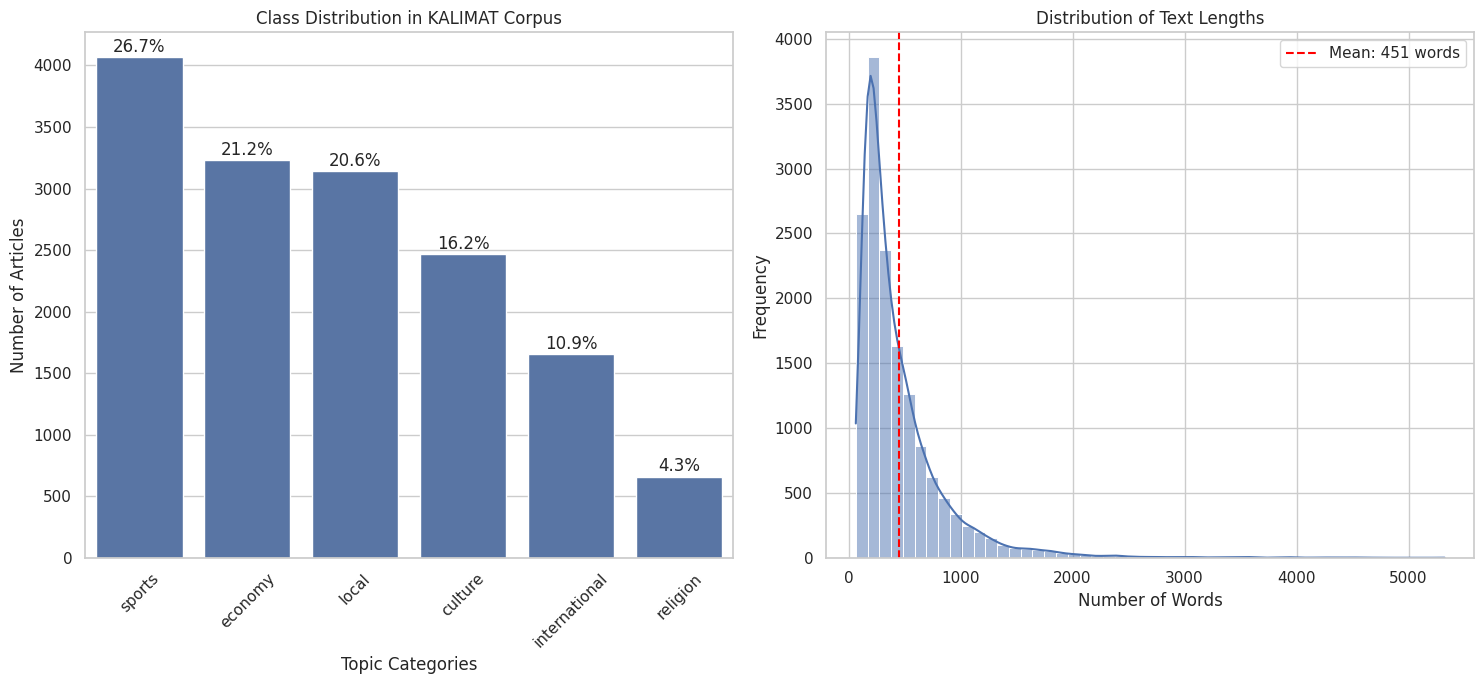

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Class distribution
sns.countplot(
    data=classification_df,
    x="label",
    order=classification_df["label"].value_counts().index,
    ax=ax1,
)
ax1.set_title("Class Distribution in KALIMAT Corpus")
ax1.set_xlabel("Topic Categories")
ax1.set_ylabel("Number of Articles")
ax1.tick_params(axis="x", rotation=45)

total = len(classification_df)
for i, (label, count) in enumerate(classification_df["label"].value_counts().items()):
    percentage = (count / total) * 100
    ax1.text(i, count + 10, f"{percentage:.1f}%", ha="center", va="bottom")


# Text length distribution
text_lengths = classification_df["text"].apply(lambda x: len(x.split()))
sns.histplot(text_lengths, bins=50, kde=True, ax=ax2)
ax2.set_title("Distribution of Text Lengths")
ax2.set_xlabel("Number of Words")
ax2.set_ylabel("Frequency")
ax2.axvline(
    text_lengths.mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {text_lengths.mean():.0f} words",
)
ax2.legend()

plt.tight_layout()
plt.show()

#### Summarization Corpus

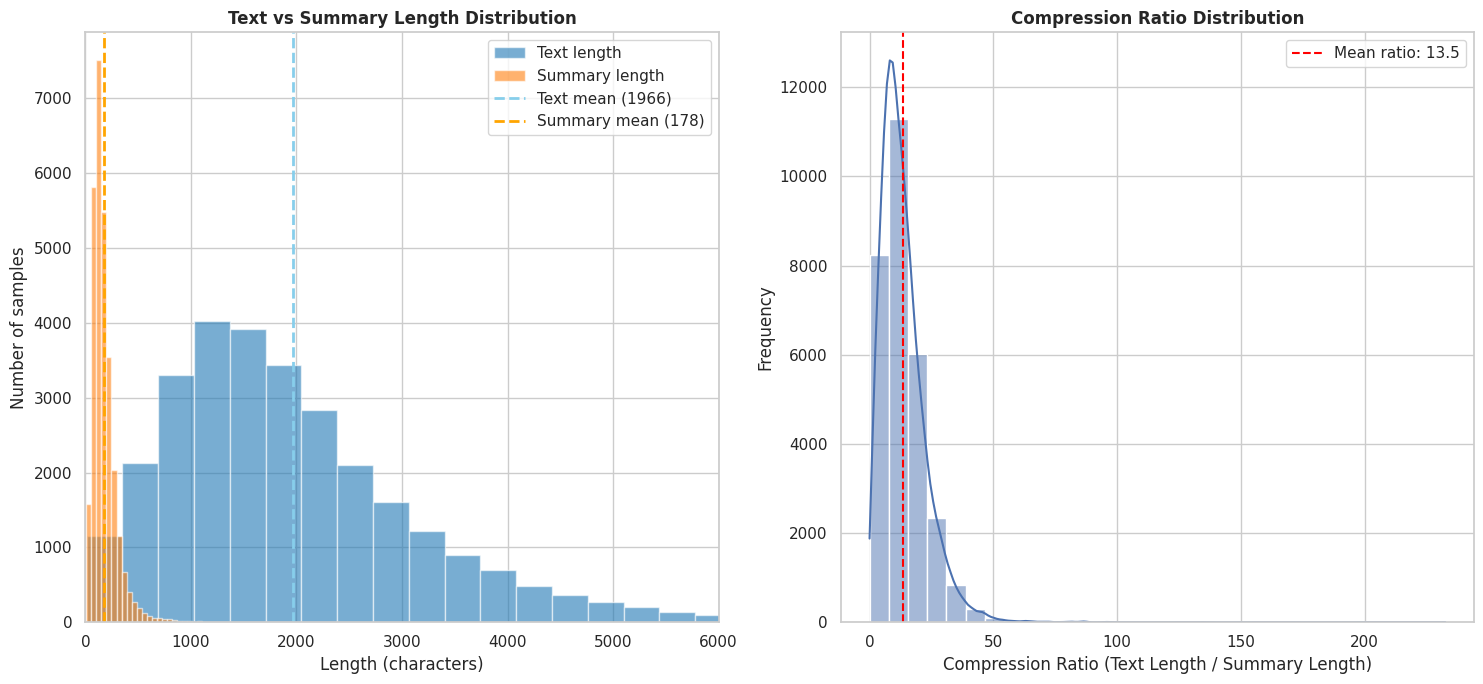

In [ ]:
# assume df already has summary_length & text_length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

text_mean = summarization_df["text_length"].mean()
summary_mean = summarization_df["summary_length"].mean()

# Length distribution
ax1.hist(
    summarization_df["text_length"],
    bins=50,
    alpha=0.6,
    label="Text length",
    color="#1f77b4",
)
ax1.hist(
    summarization_df["summary_length"],
    bins=50,
    alpha=0.6,
    label="Summary length",
    color="#ff7f0e",
)

ax1.set_xlim(0, 6000)
ax1.axvline(
    text_mean,
    color="skyblue",
    linestyle="--",
    linewidth=2,
    label=f"Text mean ({text_mean:.0f})",
)
ax1.axvline(
    summary_mean,
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Summary mean ({summary_mean:.0f})",
)

ax1.set_xlabel("Length (characters)")
ax1.set_ylabel("Number of samples")
ax1.set_title("Text vs Summary Length Distribution", fontweight="bold")
ax1.legend()

# Compression ratio
compression_ratio = summarization_df["text_length"] / summarization_df["summary_length"]
sns.histplot(compression_ratio, bins=30, kde=True, ax=ax2)
ax2.set_title("Compression Ratio Distribution", fontweight="bold")
ax2.set_xlabel("Compression Ratio (Text Length / Summary Length)")
ax2.set_ylabel("Frequency")
ax2.axvline(
    compression_ratio.mean(),
    color="red",
    linestyle="--",
    label=f"Mean ratio: {compression_ratio.mean():.1f}",
)
ax2.legend()

plt.tight_layout()
plt.show()

### Data Characteristics Insights

**KALIMAT Corpus Observations**:
- Somewhat imbalanced class distribution with sports articles dominating (~25% of dataset)
- Text lengths vary significantly across topics (economics articles tend to be longer)
- Average Arabic text contains ~450 words, requiring careful sequence length management for neural models

**Summarization Corpus Patterns**:
- High compression ratios (13.5) which means summarization is much shorter
- Length variability suggests diverse text types and summarization styles
- Arabic summary quality appears inconsistent, affecting evaluation metrics

These patterns inform preprocessing decisions and model architecture choices.





## 3. Phase 1: Traditional Approaches

In [ ]:
print("Creating train/test splits on preprocessed text...")

# Classification data split
X_cls = classification_df["preprocessed_text"]
y_cls = classification_df["label"]
X_cls_train_raw, X_cls_test_raw, y_cls_train_raw, y_cls_test_raw = train_test_split(
    X_cls, y_cls, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_cls
)

# Preserve original string labels
y_cls_train_str = y_cls_train_raw.copy()
y_cls_test_str = y_cls_test_raw.copy()

# Encode labels
label_encoder = LabelEncoder()
y_cls_train_raw = label_encoder.fit_transform(y_cls_train_raw)
y_cls_test_raw = label_encoder.transform(y_cls_test_raw)

print(
    f"Classification split - Training: {len(X_cls_train_raw):,}, Test: {len(X_cls_test_raw):,}"
)
print(f"Label classes: {list(label_encoder.classes_)}")

Creating train/test splits on preprocessed text...
Classification split - Training: 12,176, Test: 3,045
Label classes: ['culture', 'economy', 'international', 'local', 'religion', 'sports']


### Traditional implementation of Task 1

In [ ]:
print("Training traditional SVM model...")

X_cls_train_preprocessed = X_cls_train_raw.tolist()
X_cls_test_preprocessed = X_cls_test_raw.tolist()

# Check if TF-IDF vectorizer exists
svm_tfidf_path = os.path.join(
    MODEL_SAVE_DIR, "traditional_tfidf_vectorizer_classifier.joblib"
)

if os.path.exists(svm_tfidf_path):
    print("Loading existing TF-IDF vectorizer for classification...")
    svm_vectorizer = joblib.load(svm_tfidf_path)
    X_cls_train_tfidf = svm_vectorizer.transform(X_cls_train_preprocessed)
    X_cls_test_tfidf = svm_vectorizer.transform(X_cls_test_preprocessed)
    print("✓ TF-IDF vectorizer loaded from file")
else:
    print("Creating new TF-IDF vectorizer...")
    # Create TF-IDF features
    svm_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X_cls_train_tfidf = svm_vectorizer.fit_transform(X_cls_train_preprocessed)
    X_cls_test_tfidf = svm_vectorizer.transform(X_cls_test_preprocessed)

    # Save the vectorizer
    joblib.dump(svm_vectorizer, svm_tfidf_path)
    print("✓ TF-IDF vectorizer created and saved")

print(f"TF-IDF feature matrix shape: {X_cls_train_tfidf.shape}")

Training traditional SVM model...
Loading existing TF-IDF vectorizer for classification...
✓ TF-IDF vectorizer loaded from file
TF-IDF feature matrix shape: (12176, 10000)


In [ ]:
# Check if model exists
svm_model_path = os.path.join(MODEL_SAVE_DIR, "traditional_svm_classifier.joblib")

if os.path.exists(svm_model_path):
    print("Loading existing SVM model...")
    svm_model = joblib.load(svm_model_path)
    print("✓ SVM model loaded from file")
else:
    print("Training new SVM model...")
    svm_model = SVC(kernel="linear", C=1, random_state=RANDOM_SEED)
    svm_model.fit(X_cls_train_tfidf, y_cls_train_raw)

    # Save the model
    joblib.dump(svm_model, svm_model_path)
    print("✓ SVM model trained and saved")

svm_preds = svm_model.predict(X_cls_test_tfidf)

Loading existing SVM model...
✓ SVM model loaded from file


### Traditional implementation of Task 2

In [ ]:
summarization_train_df, summarization_test_df = train_test_split(
    summarization_df, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

X_sum_train = summarization_train_df["text"].tolist()
X_sum_test = summarization_test_df["text"].tolist()
y_sum_train = summarization_train_df["summary"].tolist()
y_sum_test = summarization_test_df["summary"].tolist()

#  Preprocess
X_sum_train = [preprocess_for_summarization(t) for t in X_sum_train]
X_sum_test = [preprocess_for_summarization(t) for t in X_sum_test]
y_sum_train = [preprocess_for_summarization(t) for t in y_sum_train]
y_sum_test = [preprocess_for_summarization(t) for t in y_sum_test]

print(f"Summarization split - Training: {len(X_sum_train)}, Test: {len(X_sum_test)}")

Summarization split - Training: 23353, Test: 5839


In [ ]:
def create_tfidf_vectorizer(corpus):
    vectorizer = TfidfVectorizer(stop_words=None, max_features=5000)
    vectorizer.fit(corpus)
    return vectorizer


def extract_tfidf_summary(text, vectorizer, num_sentences=3):
    cleaned_text = preprocess_for_summarization(text)
    sentences = re.split(r"[.!؟\n]+", cleaned_text)
    sentences = [s.strip() for s in sentences if s.strip() and len(s.split()) > 3]

    if len(sentences) <= num_sentences:
        return " ".join(sentences)

    try:
        tfidf_matrix = vectorizer.transform(sentences)
        sentence_scores = tfidf_matrix.sum(axis=1).A1
        top_indices = np.argsort(sentence_scores)[-num_sentences:][::-1]
        summary_sentences = [sentences[i] for i in sorted(top_indices)]
        return ". ".join(summary_sentences) + "."
    except:
        return ". ".join(sentences[:num_sentences]) + "."


print("✓ Traditional summarization functions loaded!")

✓ Traditional summarization functions loaded!


In [ ]:
print("Setting up TF-IDF vectorizer for summarization...")

# Check if TF-IDF vectorizer for summarization exists
tfidf_sum_path = os.path.join(
    MODEL_SAVE_DIR, "traditional_tfidf_vectorizer_summarization.joblib"
)

if os.path.exists(tfidf_sum_path):
    print("Loading existing TF-IDF vectorizer for summarization...")
    tfidf_vectorizer = joblib.load(tfidf_sum_path)
    print("✓ TF-IDF vectorizer loaded from file")
else:
    print("Training new TF-IDF vectorizer for summarization...")

    # Use training set for fitting the vectorizer
    train_texts_clean = [
        preprocess_for_summarization(text)
        for text in tqdm(X_sum_train, desc="Preprocessing training texts")
    ]

    tfidf_vectorizer = create_tfidf_vectorizer(train_texts_clean)

    # Save the vectorizer
    joblib.dump(tfidf_vectorizer, tfidf_sum_path)
    print("✓ TF-IDF vectorizer created and saved")

print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print("✓ TF-IDF vectorizer ready!")

Setting up TF-IDF vectorizer for summarization...
Loading existing TF-IDF vectorizer for summarization...
✓ TF-IDF vectorizer loaded from file
TF-IDF vocabulary size: 5,000
✓ TF-IDF vectorizer ready!


In [ ]:
tfidf_summaries = []
for text in tqdm(X_sum_test, desc="Generating TF-IDF summaries"):
    summary = extract_tfidf_summary(text, tfidf_vectorizer, num_sentences=3)
    tfidf_summaries.append(summary)

print(f"Generated {len(tfidf_summaries):,} TF-IDF summaries")

Generating TF-IDF summaries: 100%|██████████| 5839/5839 [00:07<00:00, 820.74it/s]

Generated 5,839 TF-IDF summaries


In [ ]:
print("\nSample TF-IDF summary:")
sample_idx = 0
print_text_sample(X_sum_test[sample_idx], "Original Text")
print_text_sample(y_sum_test[sample_idx], "Reference Summary")
print_text_sample(tfidf_summaries[sample_idx], "TF-IDF Summary")


Sample TF-IDF summary:

Original Text:


ما بين تجهيز نفسك، أو العناية بالحيوانات الأليفة والأطفال أو القيام بالمهام المنزلية السابقة للعمل، أنت منشغل بمهام كثيرة في الصباح. قلل الحمل عن طريق تحضير الفطور والغذاء الليلة السابقة. عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. أبق مستويات طاقاتك عالية. الطاقة التي حصلت عليها من تناول العشاء الليلة السابقة تنفذ مع الصباح. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. تحتاج إلى طاقة لأقصى كم من التحفيز في الصباح وطوال اليوم. تجنب الكربوهيدرات المكررة مثل الكعك لأنها ترفع سكر الدم بشكل مفاجئ ثم يهبط فجأة. ابق فطورك بسيطا ومغذيا. اسلق البيض وضعه في الثلاجة ليكون متاحا في الصباحات المشغولة. استمتع ببيض مسلوق مع مافن انجليزي وثمرة موز لفطور متوازن. كخيار آخر يمكنك طهي الشوفان في الطاهي البطيء ليلا. استمتع بشوفان ساخن وفواكه في الصباح واحتفظ بالباقي في الثلاجة لفطور سريع باقي الأسبوع. جهز غداء متوازن. استخدم وعاء واسع الفم لصنع سلطة عالية البروتين. ضع تتبيلة السلطة في قاع الوعاء. بعد ذلك، رتب الخضروات في طبقات كالخيار، الطماطم الكرز، الجزر، والحمص. أضف بروتين خالي من الدهون كالدجاج المشوي. أخيرا أضف الخضروات الورقية على السطح، اغلق الوعاء وضعه في الثلاجة. ستبقى السلطة طازجة طوال الليل بما أن الخضروات مفصولة عن التتبيلة. عندما تكون مستعدا لتناول الغداء، قم فقط برج الوعاء لتوزيع التتبيلة ثم اسكبها في طبق. يستخدم جسمك طعام العشاء كوقود أثناء النوم. ستستيقظ بطاقة وحماس أكبر عندما تقوم شحن جسمك بالأطعمة الصحيحة في الليلة السابقة. تناول البروتينات خالية الدهون مثل الدجاج المشوي، السمك أو الفول. أضف الخضروات والكربوهيدرات المعقدة مثل الأرز البني أو الكينوا. يستخدم جسمك الكثير من الطاقة لهضم الطعام. تناول وجبة دسمة قرب وقت النوم يصعب من عملية النوم. تناول الطعام قبل النوم بساعتين أو ثلاث ساعات. هذا يعطي جسمك وقتا لإنهاء الهضم قبل أن تنام. تجنب الأطعمة السكرية أو الدسمة لأنها تؤدي إلى رفع معدل سكر الدم فجأة أو حرقة المعدة. كلا الأمران يصعب من النوم. التابلت، والتليفون الذكي، والحاسوب، والتلفاز كلها أشياء تحفز العقل. أنت في مزاج تفكير بدلا من مزاج استرخاء. العقل المحفز يصعب النوم. عندما يتشتت نومك، سيصعب عليك البقاء أن تصبح محفزا في الصباح. اغلق كل الأجهزة الالكترونية قبل النوم بساعة على الأقل. الإضاءة الاصطناعية التي تأتي من الأجهزة الالكترونية تصيب الساعة البيولوجية بالاضطراب. كذلك تكبح هرمون النوم الميلاتونين، الذي يجعلك تبقى مستيقظا لفترة أطول. النوم المشوش يعني أنك تشعر بالكسل والانزعاج في الصباح. الكافيين يبقيك منتبها لعدة ساعات. ستحتاج إلى وقت أطول للنوم وستعاني من النوم المتقطع عندما تستهلك الكافيين ليلا. ستستيقظ شاعرا بالترنح بدلا من النشاط. تجنب المشروبات التي تحتوي على كافيين كالقهوة، الشاي، أو الصودا لمدة أربع ساعات على الأقل قبل موعد النوم. اشرب مشروبات لا تحتوي على كافيين كبديل مثل الشاي اخالي من الكافيين أو الحليب الدافئ. لهذا تأثير مهدئ. سيكون النوم والبقاء نائما أسهل عليك. شرب كأس أخير قبل النوم لا يبعث على الاسترخاء كما تظن. الكحول هو مسبب للاكتئاب لذا يجعلك تشعر بالنعاس أولا. عندما يختفي مفعول الكحول، له تأثير محفز. ستستيقظ وتشعر بصعوبة النوم مجددا. الكحول يسبب اضطرابا في دورات نومك أيضا، لذا لن تحصل على نوع النوم الذي تحتاجه للشعور بالراحة. قلل الكحول إلى كأس أو اثنين يوميا. اشرب اخر مشروب قبل النوم بساعتين على الأقل. روتين النوم ليس فقط للأطفال. درب عقلك وجسمك على النوم والبقاء نائما. الراحة جيدا أساسية لبدء صباحك شاعرا بالطاقة والتركيز. اقرأ كتابا أو مجلة قديمة. ستتعب عقلك وتنام بسهولة بشكل أسهل عندما تقرأ. تجنب القراءة من جهاز إلكتروني لأن ضوء الجهاز يمكن أن يبقيك مستيقظا. بالإضافة إلى ذلك، ستشعر بالرغبة في التحقق من رسائلك أو تطبيقاتك. أرخ عضلاتك. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك. عضلاتك مشدودة بسبب يومك المشغول. الحمام أو تمديد عضلاتك يساعدك على الراحة والاستغراق في النوم. اهدف إلى سبع إلى تسع ساعات من النوم كل ليلة. هذه الكمية ستسمح لك أن تمر بكل دورات النوم. هناك أربع مراحل من النوم تتكرر حوالي كل  دقيقة. إذا كنت تنام أقل من سبع ساعات، لا يمكنك المرور خلال كل المراحل. اعلم أن النوم مهم لصحتك العامة. الحرمان من النوم يؤدي إلى فقدان الذاكرة، وقلة التركيز والإعياء. النوم جيدا بشكل منتظم يحفز نظامك المناعي ويساعدك على التحكم في وزنك. الراحة ليلا تحسن طاقتك، تحفيزك وصحتك العامة.


[Full length: 4,110 characters]


Reference Summary:


حضر فطورك وغذائك الليلة السابقة. تناول عشاءا صحيا. اغلق الأجهزة الكهربائية قبل النوم. تجنب الكافيين قبل النوم. تجنب الكحول قبل النوم. رتب روتينا للنوم.


[Full length: 151 characters]


TF-IDF Summary:


عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك.


[Full length: 374 characters]



### Evaluation and results analysis

#### Task 1

### Traditional Methods Evaluation

#### Classification Results (SVM)

SVM Classification Results:


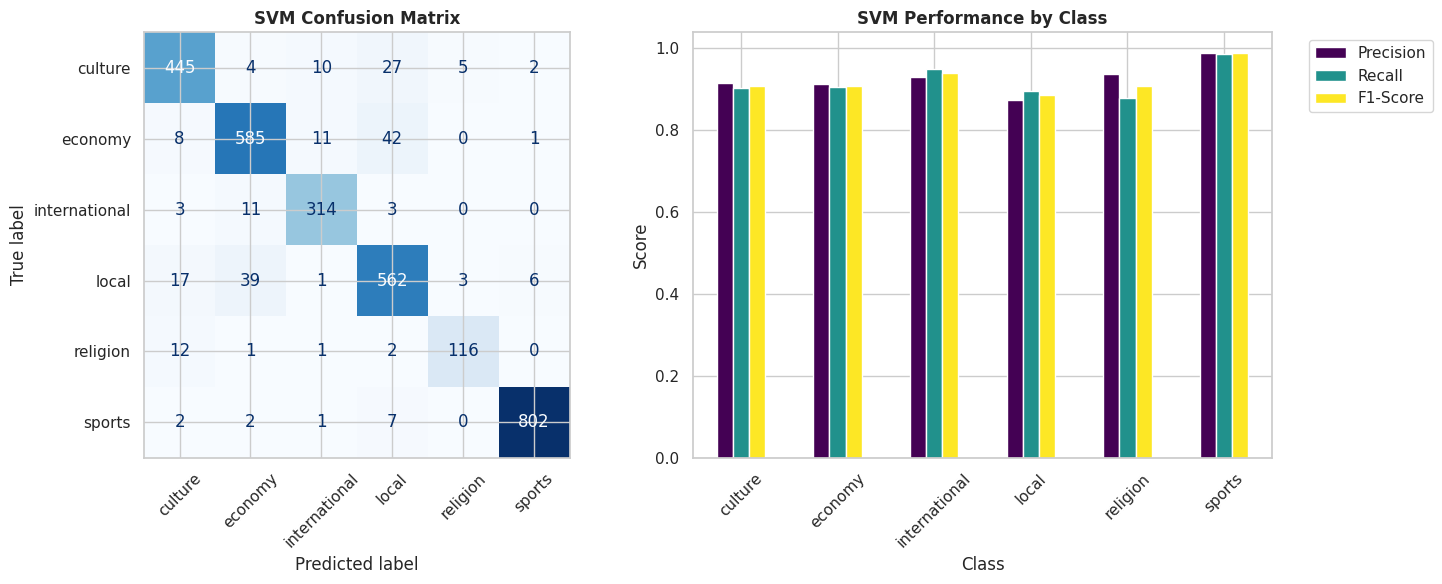

In [ ]:
print("SVM Classification Results:")
print("=" * 40)

labels = list(label_encoder.classes_)

svm_preds = label_encoder.inverse_transform(svm_preds)
# Confusion Matrix
cm_svm = confusion_matrix(y_cls_test_str, svm_preds, labels=labels)
svm_accuracy = cm_svm.diagonal().sum() / cm_svm.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
disp.plot(cmap="Blues", ax=ax1, colorbar=False)
ax1.set_title("SVM Confusion Matrix", fontweight="bold")
ax1.tick_params(axis="x", rotation=45)

# Classification metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_cls_test_str, svm_preds, labels=labels, zero_division=0
)

metrics_df = pd.DataFrame(
    {
        "Class": labels,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Support": support,
    }
)

metrics_df.set_index("Class")[["Precision", "Recall", "F1-Score"]].plot(
    kind="bar", ax=ax2, colormap="viridis"
)
ax2.set_title("SVM Performance by Class", fontweight="bold")
ax2.set_ylabel("Score")
ax2.tick_params(axis="x", rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
print("\n=== SVM Classification Report ===")
print(classification_report(y_cls_test_str, svm_preds, labels=labels))


=== SVM Classification Report ===
               precision    recall  f1-score   support

      culture       0.91      0.90      0.91       493
      economy       0.91      0.90      0.91       647
international       0.93      0.95      0.94       331
        local       0.87      0.89      0.88       628
     religion       0.94      0.88      0.91       132
       sports       0.99      0.99      0.99       814

     accuracy                           0.93      3045
    macro avg       0.93      0.92      0.92      3045
 weighted avg       0.93      0.93      0.93      3045



#### Task 2

In [ ]:
print("Evaluating TF-IDF Summarization:")
print("=" * 40)

# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=False)

rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

print("Calculating ROUGE scores...")
for reference, generated in tqdm(
    zip(y_sum_test, tfidf_summaries), total=len(y_sum_test), desc="ROUGE evaluation"
):
    reference = str(reference)
    generated = str(generated)

    if reference and generated:
        scores = scorer.score(reference, generated)
        for metric in rouge_scores:
            rouge_scores[metric].append(scores[metric].fmeasure)

# Calculate and display results
rouge_results = {}
for metric in rouge_scores:
    rouge_results[metric] = np.mean(rouge_scores[metric])

print("\nTF-IDF Summarization Results:")
for metric, score in rouge_results.items():
    print(f"{metric.upper()}: {score:.4f}")

# BLEU Score calculation
print("\nCalculating BLEU scores...")
smooth = SmoothingFunction().method1
refs = [[ref.split()] for ref in y_sum_test]
cands = [cand.split() for cand in tfidf_summaries]

bleu_scores = {
    "BLEU-1": corpus_bleu(refs, cands, weights=(1, 0, 0, 0), smoothing_function=smooth),
    "BLEU-2": corpus_bleu(
        refs, cands, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth
    ),
    "BLEU-3": corpus_bleu(
        refs, cands, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth
    ),
    "BLEU-4": corpus_bleu(
        refs, cands, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth
    ),
}

for metric, score in bleu_scores.items():
    print(f"{metric}: {score:.4f}")

traditional_results = {
    "SVM_Accuracy": classification_report(
        label_encoder.inverse_transform(y_cls_test_raw), svm_preds, output_dict=True
    )["accuracy"],
    "TF-IDF_ROUGE1": rouge_results["rouge1"],
    "TF-IDF_BLEU1": bleu_scores["BLEU-1"],
}

print("\n✓ Traditional methods evaluation complete!")

Evaluating TF-IDF Summarization:
Calculating ROUGE scores...


ROUGE evaluation: 100%|██████████| 5839/5839 [00:05<00:00, 1150.58it/s]



TF-IDF Summarization Results:
ROUGE1: 0.1327
ROUGE2: 0.0301
ROUGEL: 0.0957

Calculating BLEU scores...
BLEU-1: 0.0776
BLEU-2: 0.0340
BLEU-3: 0.0176
BLEU-4: 0.0090

✓ Traditional methods evaluation complete!


In [ ]:
print("Sample Traditional Summarization Results:")
print("=" * 50)

for i in [0, 1, 2]:
    print(f"\n--- Sample {i + 1} ---")
    print_text_sample(X_sum_test[i], "Original Text")
    print_text_sample(y_sum_test[i], "Reference Summary")
    print_text_sample(tfidf_summaries[i], "TF-IDF Generated Summary")
    print("-" * 50)

Sample Traditional Summarization Results:

--- Sample 1 ---

Original Text:


ما بين تجهيز نفسك، أو العناية بالحيوانات الأليفة والأطفال أو القيام بالمهام المنزلية السابقة للعمل، أنت منشغل بمهام كثيرة في الصباح. قلل الحمل عن طريق تحضير الفطور والغذاء الليلة السابقة. عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. أبق مستويات طاقاتك عالية. الطاقة التي حصلت عليها من تناول العشاء الليلة السابقة تنفذ مع الصباح. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. تحتاج إلى طاقة لأقصى كم من التحفيز في الصباح وطوال اليوم. تجنب الكربوهيدرات المكررة مثل الكعك لأنها ترفع سكر الدم بشكل مفاجئ ثم يهبط فجأة. ابق فطورك بسيطا ومغذيا. اسلق البيض وضعه في الثلاجة ليكون متاحا في الصباحات المشغولة. استمتع ببيض مسلوق مع مافن انجليزي وثمرة موز لفطور متوازن. كخيار آخر يمكنك طهي الشوفان في الطاهي البطيء ليلا. استمتع بشوفان ساخن وفواكه في الصباح واحتفظ بالباقي في الثلاجة لفطور سريع باقي الأسبوع. جهز غداء متوازن. استخدم وعاء واسع الفم لصنع سلطة عالية البروتين. ضع تتبيلة السلطة في قاع الوعاء. بعد ذلك، رتب الخضروات في طبقات كالخيار، الطماطم الكرز، الجزر، والحمص. أضف بروتين خالي من الدهون كالدجاج المشوي. أخيرا أضف الخضروات الورقية على السطح، اغلق الوعاء وضعه في الثلاجة. ستبقى السلطة طازجة طوال الليل بما أن الخضروات مفصولة عن التتبيلة. عندما تكون مستعدا لتناول الغداء، قم فقط برج الوعاء لتوزيع التتبيلة ثم اسكبها في طبق. يستخدم جسمك طعام العشاء كوقود أثناء النوم. ستستيقظ بطاقة وحماس أكبر عندما تقوم شحن جسمك بالأطعمة الصحيحة في الليلة السابقة. تناول البروتينات خالية الدهون مثل الدجاج المشوي، السمك أو الفول. أضف الخضروات والكربوهيدرات المعقدة مثل الأرز البني أو الكينوا. يستخدم جسمك الكثير من الطاقة لهضم الطعام. تناول وجبة دسمة قرب وقت النوم يصعب من عملية النوم. تناول الطعام قبل النوم بساعتين أو ثلاث ساعات. هذا يعطي جسمك وقتا لإنهاء الهضم قبل أن تنام. تجنب الأطعمة السكرية أو الدسمة لأنها تؤدي إلى رفع معدل سكر الدم فجأة أو حرقة المعدة. كلا الأمران يصعب من النوم. التابلت، والتليفون الذكي، والحاسوب، والتلفاز كلها أشياء تحفز العقل. أنت في مزاج تفكير بدلا من مزاج استرخاء. العقل المحفز يصعب النوم. عندما يتشتت نومك، سيصعب عليك البقاء أن تصبح محفزا في الصباح. اغلق كل الأجهزة الالكترونية قبل النوم بساعة على الأقل. الإضاءة الاصطناعية التي تأتي من الأجهزة الالكترونية تصيب الساعة البيولوجية بالاضطراب. كذلك تكبح هرمون النوم الميلاتونين، الذي يجعلك تبقى مستيقظا لفترة أطول. النوم المشوش يعني أنك تشعر بالكسل والانزعاج في الصباح. الكافيين يبقيك منتبها لعدة ساعات. ستحتاج إلى وقت أطول للنوم وستعاني من النوم المتقطع عندما تستهلك الكافيين ليلا. ستستيقظ شاعرا بالترنح بدلا من النشاط. تجنب المشروبات التي تحتوي على كافيين كالقهوة، الشاي، أو الصودا لمدة أربع ساعات على الأقل قبل موعد النوم. اشرب مشروبات لا تحتوي على كافيين كبديل مثل الشاي اخالي من الكافيين أو الحليب الدافئ. لهذا تأثير مهدئ. سيكون النوم والبقاء نائما أسهل عليك. شرب كأس أخير قبل النوم لا يبعث على الاسترخاء كما تظن. الكحول هو مسبب للاكتئاب لذا يجعلك تشعر بالنعاس أولا. عندما يختفي مفعول الكحول، له تأثير محفز. ستستيقظ وتشعر بصعوبة النوم مجددا. الكحول يسبب اضطرابا في دورات نومك أيضا، لذا لن تحصل على نوع النوم الذي تحتاجه للشعور بالراحة. قلل الكحول إلى كأس أو اثنين يوميا. اشرب اخر مشروب قبل النوم بساعتين على الأقل. روتين النوم ليس فقط للأطفال. درب عقلك وجسمك على النوم والبقاء نائما. الراحة جيدا أساسية لبدء صباحك شاعرا بالطاقة والتركيز. اقرأ كتابا أو مجلة قديمة. ستتعب عقلك وتنام بسهولة بشكل أسهل عندما تقرأ. تجنب القراءة من جهاز إلكتروني لأن ضوء الجهاز يمكن أن يبقيك مستيقظا. بالإضافة إلى ذلك، ستشعر بالرغبة في التحقق من رسائلك أو تطبيقاتك. أرخ عضلاتك. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك. عضلاتك مشدودة بسبب يومك المشغول. الحمام أو تمديد عضلاتك يساعدك على الراحة والاستغراق في النوم. اهدف إلى سبع إلى تسع ساعات من النوم كل ليلة. هذه الكمية ستسمح لك أن تمر بكل دورات النوم. هناك أربع مراحل من النوم تتكرر حوالي كل  دقيقة. إذا كنت تنام أقل من سبع ساعات، لا يمكنك المرور خلال كل المراحل. اعلم أن النوم مهم لصحتك العامة. الحرمان من النوم يؤدي إلى فقدان الذاكرة، وقلة التركيز والإعياء. النوم جيدا بشكل منتظم يحفز نظامك المناعي ويساعدك على التحكم في وزنك. الراحة ليلا تحسن طاقتك، تحفيزك وصحتك العامة.


[Full length: 4,110 characters]


Reference Summary:


حضر فطورك وغذائك الليلة السابقة. تناول عشاءا صحيا. اغلق الأجهزة الكهربائية قبل النوم. تجنب الكافيين قبل النوم. تجنب الكحول قبل النوم. رتب روتينا للنوم.


[Full length: 151 characters]


TF-IDF Generated Summary:


عندما يكون كل ما تحتاجه هو أن تأخذ الوجبة وتذهب، أنت تقلل من فرص أن تتجاهل الفطور لأنك في عجلة من أمرك وستتجنب شراء الأطعمة السريعة الغير صحية للغذاء. تناول فطور يحتوي على نسبة عالية من الألياف يوازن مستوى سكر الدم لديك، مما يساعدك على الشعور بالطاقة والمزيد من التركيز. أخذ حمام دافئ أو القيام بتمديد العضلات اللطيف هي بعض الطرق التي يمكن أن تساعدك على تخفيف الضغط من جسمك.


[Full length: 374 characters]

--------------------------------------------------

--- Sample 2 ---

Original Text:


تتخطى العديد من الماسحات وتصدر صريرا بسبب أن الزجاج الأمامي غير رطب بشكل كاف، لذلك تحقق من مستوى سائل الماسحة واملأه عند الحاجة؛ بهذه الطريقة ستكون البخاخات مستعدة للعمل إذا حدث الصرير. ماسحات الزجاج الأمامي مصممة لاتباع حركة ذراع الماسحة، لذلك إذا كانت الشفرات متصلبة ولا تتحرك خلف الذراع ذهابا وإيابا، لف الذراع بيدك لترخية صلابتها. لن تتمكن الشفرات المثبتة بإحكام شديد من التحرك ذهابا وإيابا لتتبع ذراع الماسحة بسلاسة مما يسبب احتكاكها وإحداث الصرير. ينبغي ألا تبدو شفرات الماسحة وكأنها تحفر خلال الزجاج الأمامي أو تظل عمودية أثناء المسح عليه. تسبب شفرات الماسحة الخشنة صوت حكة وصرير وقد تكون بعض شفرات الماسحة الجديدة خشنة منذ البداية، بينما قد تصبح أخرى خشنة نتيجة التعرض للعناصر المختلفة. ينبغي تغيير الشفرات التي قد مر عليها عاما كما يمكن تليين الشفرات الجديدة بواسطة ما يلي: منتج تنظيف السيارات (أرمور أول). ضع كمية وفيرة على منشفة ورقية واستخدم حركات دائرية مع تمرير المنتج على مطاط شفرة الماسحة لتنعيمها. الكحول المحمر. بلل منشفة ورقية بالكحول المحمر ولمع مطاط الشفرة برفق. منتج wd-. استخدم ذلك المنتج بحرص إذ قد يسبب الكثير منه تجفيف المطاط. رش القليل من المنتج على منشفة ورقية ومررها برفق على مطاط الشفرة ثم جففه. افحص لترى إذا كانت الشفرات أو أجزاء الماسحة الموجودة أدناها مرتخية جدا أو مربوطة جدا؛ قد يسبب الاحتكاك القليل أو الكثير جدا بين الزجاج والماسحة إصدار صوت الاحتكاك والصرير. يمكن ربط البراغي بإحكام في العموم باستخدام مفتاح البراغي عن طريق لفه باتجاه عقارب الساعة وترخيتها عن طريق لفه باتجاه معاكس لحركة عقارب الساعة. قد تحتاج إلى اختبار مستوى الربط لتجد ما يعمل أفضل؛ من الأمثل أن تكون الشفرات مثبتة في موضعها جيدا لكن ينبغي أن تزال مرتخية بشكل كاف لتتمكن من المسح ذهابا وإيابا على زجاج السيارة. قد تسبب بعض الدهانات الواقية للسطح، مثل الطلاء الواقي من المطر أو بعض أنواع الشمع الاحتكاك والصرير. أزل المنتج وقلل من صوت الماسحة المزعج عن طريق استخدام ملمع السيارة العادي. قد يسبب الطلاء المتروك بواسطة بعض منتجات سطح السيارات زيادة الاحتكاك بين شفرات الماسحة والزجاج الأمامي للسيارة محدثا الأصوات المزعجة، مثل الصرير.


[Full length: 1,940 characters]


Reference Summary:


أعد ملء سائل ماسحة الزجاج الأمامي. اضبط موضع شفرات الماسحات حسب الحاجة. لين ماسحات الزجاج الأمامي. اضبط إحكام البراغي. أزل الأغلفة المسببة لزيادة الاحتكاك.


[Full length: 155 characters]


TF-IDF Generated Summary:


تتخطى العديد من الماسحات وتصدر صريرا بسبب أن الزجاج الأمامي غير رطب بشكل كاف، لذلك تحقق من مستوى سائل الماسحة واملأه عند الحاجة؛ بهذه الطريقة ستكون البخاخات مستعدة للعمل إذا حدث الصرير. ينبغي تغيير الشفرات التي قد مر عليها عاما كما يمكن تليين الشفرات الجديدة بواسطة ما يلي: منتج تنظيف السيارات (أرمور أول). قد تحتاج إلى اختبار مستوى الربط لتجد ما يعمل أفضل؛ من الأمثل أن تكون الشفرات مثبتة في موضعها جيدا لكن ينبغي أن تزال مرتخية بشكل كاف لتتمكن من المسح ذهابا وإيابا على زجاج السيارة.


[Full length: 485 characters]

--------------------------------------------------

--- Sample 3 ---

Original Text:


تحتاج بالضرورة إلى نسخة مسجلة من أغنياتك، حتى ولو بشكل تجريبي، لتقدر على لفت انتباه شركات الإنتاج والتوزيع، كما أن المعجبين سيحبون سماع أغنيتك بنسخة الأستديو بدلا من التسجيل متوسط المستوى من الحفلات أو التسجيلات العادية، لذا انشر لهم نسخة من تسجيلاتك في الأستديو لأغنياتك المشهورة، وكذلك القليل من الأغنيات الجديدة التي لم يسبق لهم سماعها من قبل. تختلف تكلفة الساعة في أستديوهات التسجيل من أستديو لآخر ومن مدينة لأخرى. اسأل عن الأسعار في مدينتك، مع ملاحظة أنه توجد تكلفة من أجل عملية التسجيل الأساسية، وتكلفة إضافية مكلفة أكثر من أجل عمليات المكساج والتحسين (ماسترينغ). قد تكون التكلفة المالية باهظة ولا تقدر على تحملها، لذا من الأفضل أن تجعل تسجيلاتك التجريبية مقتصرة على واحدة أو اثنين من أفضل أغانيك، جاعلا كل تركيزك منصبا على تسجيل الأغنيتين بكفاءة وبأعلى جودة ممكنة، وفي أقل وقت ممكن (من أجل تقليل النفقات التي تدفعها للأستديو نظير كل ساعة تأجير). لكل مهندس أو منتج صوتي أسلوبه المختلف في تنظيم جلسات التسجيل، لكن يفضل أن تحرص بدورك على إتمام مهمتك (تسجيل الأغنية) في الأستديو بفاعلية وسرعة قدر الإمكان. طالما أنك تعلم طبيعة الأغنية عن ظهر قلب، وتعرف ما ترغب في تقديمه بها من كلمات وألحان وتوزيع، فعلى الأغلب لن تحتاج للتجريب أو التسجيل أكثر من مرة من أجل الوصول لأفضل نتيجة. أجر عملية دراسة مسبقة للتعرف على طريقة تسجيل الأغنيات والمعدات المتاحة للاستخدام في الأستديوهات قبل الحجز. على سبيل المثال، يجب أن تتفق مع فرقتك الموسيقية حول ما إذا كان الأفضل لهم هو التسجيل سويا في نفس الوقت أم التسجيل لكل منهم بشكل منفرد، وكذلك مختلف خيارات التسجيل التي ترغب في أن يلتزم مهندس الصوت بتطبيقها. لا تقم أبدا بالتسجيل بواسطة معدات غير مألوفة بالنسبة لك. من المغري للغاية الخضوع لرغبة حجز معدات وآلات موسيقية فاخرة وغالية الثمن، طمعا في استخدامها ولو لمرة واحدة وظنا أنها كافية بحد ذاتها لتسجيل أغنية خيالية، لكن التعامل مع معدات مجهولة سوف يستهلك وقتك في الأستديو دون الحصول على أي نتائج مجدية. لن تستفيد كثيرا من أن تدرج في أغانيك مؤثرات صوتية رائعة، لها دور مؤثر وأساسي في شكل الأغنية، لكنك لن تقدر على إعادة إنتاجها بنفسك في تسجيلات الأغنية وأثناء أداء الأغنية بشكل حي في الحفلات. لا تضيع تكلفة الأستديو على تسجيل أغنية لفرقة موسيقية أخرى أو أغنية ذات طابع مغاير مقارنة بأغلب أغانيك، بل احرص على تسجيل أفضل أغانيك والتي تعبر بوضوح عن نوعية ما تقدمه من كلمات وموسيقى وأداء غنائي. هذه النسخة التجريبية بمثابة ملف السيرة الذاتية الخاص بك كمغني أو فرقة موسيقية، لذا فكر بعناية من أجل اختيار الأغنية التي تمثلك وتعبر عن موسيقاك. ما هي الأغنية الأفضل من أغانيك الأصلية؟ ما هي الأغنية التي يحبها الجمهور أكثر؟ لن يكون وقت تسجيل أسطوانتك التجريبية الأولى مناسبا للاستغراق المتهمل في العمل على أغنية جديدة لم تعرف شكلا نهائيا مميزا لتأديتها بعد أو لمحاولة الارتجال على نغمة موسيقية جديدة، بل استغل الوقت في تسجيل الأغنيات المميزة التي تضمن أنها ستخرج بصورة جيدة وتنال إعجاب من يستمع إليها. يمكنك تسجيل أغنيات بجودة احترافية بنفسك ورفعها على الإنترنت في نفس اليوم، بشرط امتلاكك لجهاز كمبيوتر مناسب والقليل من الميكروفونات الجيدة رخيصة السعر. مع تطور التكنولوجيا المستخدمة وتوفر المعدات، أصبحت العديد من الفرق الموسيقية تلجأ إلى التسجيل الذاتي وعمل أستديوهات منزلية بسيطة من أجل تجنب التكلفة الباهظة للأستديوهات، لذا لا تتردد حيال استغلال أي فرصة ممكنة لتوفير النفقات، على أن توجه ميزانية الفرقة الموسيقية إلى الإنفاق على الجولات الغنائية أو شراء المزيد من المعدات الأفضل جودة. في حالة كنت تملك جهاز ماك حديث، فعلى الأغلب سيتوفر على برمجية التسجيل الصوتي "جراج باند" (garage band) ، أو يمكنك شراء البرنامج من متجر آبل للتطبيقات بسعر زهيد. يتوفر على أجهزة آبل كذلك إمكانية استخدام برنامج "لوجيك برو إكس" (logic pro x)، والذي يتيح لك المزيد من الخواص الاحترافية للاستخدام، ولكن ثمنه أغلى قليلا. تطبيق "أوداسيتي" (audacity) برمجية مجانية مفتوحة المصدر تعمل على أي جهاز كمبيوتر بنظام تشغيل ويندوز أو ماك أو جينو/ لينكس. ابحث عن مختلف خيارات التسجيل الممكنة المجانية أو الأقل سعرا المتوفرة لك في مشهد الصناعة الموسيقية المحلية، وتواصل مع أصدقائك وزملائك العاملين في مجال الفن من أجل تنسيق أي آلية ممكنة تضمن لكم تقليل النفقات والحصول على جودة تسجيل أفضل. تواصل مع غيرك من الفرق الموسيقية والمغنيين للتعرف على العروض الأفضل في سوق التسجيل الموسيقي. كثيرا ما يرحب الفنانون بتشارك هذا النوع من الموارد والمعلومات طالما أن عملية المصلحة المشتركة متحققة وكنت بدورك لا تتأخر عن تقديم المساعدة في حال كنت قادرا عليها. العصر الحالي هو العصر الذهبي للعاملين في المجالات الفنية، تحديدا فيما يتعلق بسهولة الوصول إلى الجمهور، وبتكلفة مالية أقل بكثير مقارنة بالماضي، فكل ما تحتاج إليه من أجل توسيع دائرة متابعيك هو رفع أغنياتك على يوتيوب أو ساوندكلاود، ومن ثم مشاركتها مع الجمهور عبر منصات التواصل الاجتماعي. لن تستغرق عملية إنشاء حساب في هذه الخدمات سوى دقائق معدودة، وبمجرد التواجد عليها أنت على بعد لحظات من الوصول لعدد لا نهائي من الجمهور في كل بقاع العالم. يمكنك كذلك التقدم بطلب إلى موقع آيتونز (itunes) لاستضافة أغنياتك، ولكن الأغنيات سوف تخضع للتقييم قبل إتخاذ قرار نهائي بشأنها. يلجأ البعض للاعتماد على وسيط "موزع موسيقي" (aggregator) وهي خدمة تساعدك على النشر على موقع آيتونز مقابل رسوم مالية. لا يتعامل موقع "سبوتيفاي" (spotify) مباشرة مع الفنانين أو الفرق الموسيقية، لذا اطلب من شركة إنتاجك أو الموزع الموسيقي أو الوسيط أن يتواصل معهم نيابة عنك طلبا لاستضافة أغانيك. لا تنشغل في وقت مبكر عن اللازم بمسألة تحقيق الأرباح من وراء عملك الفني، بل اجعل كل تركيزك منصبا على رفع جودة الأغاني وزيادة شهرتك واكتساب جماهيرية أوسع وأوسع. حديثا، تغير المشهد الموسيقي في العالم أجمع (الحكم على النجاح في عالم الفن) من الارتكاز حول مبيعات الألبوم الواحد، إلى الاهتمام في المقام الأول بمدى الشهرة الإلكترونية على موقع الإنترنت، سواء من خلال المتابعين على منصات فيسبوك وتويتر، أو عدد مشاهدات والاستماع إلى أغنيتك على يوتيوب وساوندكلاود وآيتونز. لذا كلما كان حضورك الإلكتروني طاغيا أكثر، كلما بادرت شركات التوزيع والإنتاج الموسيقي بالركض وراءك من أجل الحصول على توقيعك وإنتاج أعمالك.


[Full length: 5,548 characters]


Reference Summary:


ابحث عن استديو تسجيلات مناسب واسأل عن ثمن الحجز. خطط لكيفية استغلال وقتك في الأستديو بأفضل طريقة ممكنة. استفد من تسجيل أفضل أغنياتك الأصلية. جرب التسجيل الصوتي بنفسك. انشر أغانيك عبر منصات التواصل الاجتماعي الإلكترونية.


[Full length: 219 characters]


TF-IDF Generated Summary:


قد تكون التكلفة المالية باهظة ولا تقدر على تحملها، لذا من الأفضل أن تجعل تسجيلاتك التجريبية مقتصرة على واحدة أو اثنين من أفضل أغانيك، جاعلا كل تركيزك منصبا على تسجيل الأغنيتين بكفاءة وبأعلى جودة ممكنة، وفي أقل وقت ممكن (من أجل تقليل النفقات التي تدفعها للأستديو نظير كل ساعة تأجير). مع تطور التكنولوجيا المستخدمة وتوفر المعدات، أصبحت العديد من الفرق الموسيقية تلجأ إلى التسجيل الذاتي وعمل أستديوهات منزلية بسيطة من أجل تجنب التكلفة الباهظة للأستديوهات، لذا لا تتردد حيال استغلال أي فرصة ممكنة لتوفير النفقات، على أن توجه ميزانية الفرقة الموسيقية إلى الإنفاق على الجولات الغنائية أو شراء المزيد من المعدات الأفضل جودة. ابحث عن مختلف خيارات التسجيل الممكنة المجانية أو الأقل سعرا المتوفرة لك في مشهد الصناعة الموسيقية المحلية، وتواصل مع أصدقائك وزملائك العاملين في مجال الفن من أجل تنسيق أي آلية ممكنة تضمن لكم تقليل النفقات والحصول على جودة تسجيل أفضل.


[Full length: 851 characters]

--------------------------------------------------


## 4. Phase 2: Modern Deep Learning and Transformer-Based Approaches

In this phase, we implement modern deep learning and transformer-based methods for both text classification and summarization tasks. We compare their performance against the traditional approaches from Phase 1.

### Modern implementation of Task 1
Two modern approaches for Arabic text classification:
1. **LSTM Neural Network**: Deep learning approach with word embeddings
2. **BERT Transformer**: Arabic BERT model

#### LSTM Classification

In [ ]:
class KalimatDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(
            self.texts.iloc[idx] if hasattr(self.texts, "iloc") else self.texts[idx]
        )
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
print("Preparing data for modern approaches...")

y_train_encoded = y_cls_train_raw
y_test_encoded = y_cls_test_raw

X_train_preprocessed = X_cls_train_raw.tolist()
X_test_preprocessed = X_cls_test_raw.tolist()

Preparing data for modern approaches...


In [ ]:
print("Preparing LSTM model components...")

# Create tokenizer for LSTM
lstm_tokenizer = Tokenizer(num_words=LSTM_MAX_WORDS, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(X_cls_train_preprocessed)

word_index = lstm_tokenizer.word_index
print(f"Vocabulary size: {len(word_index):,}, using top {LSTM_MAX_WORDS:,}")

# Convert texts to sequences
X_train_seq = lstm_tokenizer.texts_to_sequences(X_cls_train_preprocessed)
X_test_seq = lstm_tokenizer.texts_to_sequences(X_cls_test_preprocessed)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=CLASSIFICATION_MAX_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=CLASSIFICATION_MAX_LENGTH)

print(f"Sequence shape: {X_train_pad.shape}")
print(f"Average sequence length: {np.mean([len(seq) for seq in X_train_seq]):.1f}")
print(f"Max sequence length: {CLASSIFICATION_MAX_LENGTH}")

print("✓ LSTM tokenization complete!")

Preparing LSTM model components...
Vocabulary size: 26,895, using top 10,000
Sequence shape: (12176, 512)
Average sequence length: 352.3
Max sequence length: 512
✓ LSTM tokenization complete!


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout,
    ):
        super(LSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
        )

        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, text, text_lengths=None):
        embedded = self.dropout(self.embedding(text))
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-2], hidden[-1]], dim=1))
        else:
            hidden = self.dropout(hidden[-1])

        output = self.fc(hidden)
        return output


print("✓ LSTM model class defined!")

✓ LSTM model class defined!


In [ ]:
print("Initializing LSTM model...")

X_train_tensor = torch.LongTensor(X_train_pad)
X_test_tensor = torch.LongTensor(X_test_pad)
y_train_tensor = torch.LongTensor(y_train_encoded)
y_test_tensor = torch.LongTensor(y_test_encoded)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=CLASSIFICATION_BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=CLASSIFICATION_BATCH_SIZE, shuffle=False
)

# Model parameters
INPUT_DIM = min(len(word_index) + 1, LSTM_MAX_WORDS)
OUTPUT_DIM = len(label_encoder.classes_)

# Initialize model
lstm_model = LSTMClassifier(
    INPUT_DIM,
    LSTM_EMBEDDING_DIM,
    LSTM_HIDDEN_DIM,
    OUTPUT_DIM,
    LSTM_N_LAYERS,
    True,
    LSTM_DROPOUT,
).to(device)

class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train_encoded), y=y_train_encoded
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    lstm_model.parameters(), lr=CLASSIFICATION_LEARNING_RATE, weight_decay=1e-4
)

print(
    f"Model parameters: {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad):,}"
)
print(f"Vocab: {INPUT_DIM:,}, Classes: {OUTPUT_DIM}")
print("✓ LSTM model initialized!")

Initializing LSTM model...
Model parameters: 1,632,326
Vocab: 10,000, Classes: 6
✓ LSTM model initialized!


In [ ]:
def train_lstm_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred_labels = predictions.argmax(dim=1)
        correct = (pred_labels == labels).sum().item()

        total_loss += loss.item()
        total_correct += correct
        total_samples += len(labels)

        current_acc = correct / len(labels)
        progress_bar.set_postfix(
            {"Loss": f"{loss.item():.3f}", "Acc": f"{current_acc:.3f}"}
        )

    epoch_loss = total_loss / len(data_loader)
    epoch_acc = total_correct / total_samples
    return epoch_loss, epoch_acc


def evaluate_lstm_epoch(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)

            pred_labels = predictions.argmax(dim=1)
            correct = (pred_labels == labels).sum().item()

            total_loss += loss.item()
            total_correct += correct
            total_samples += len(labels)

            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = total_loss / len(data_loader)
    epoch_acc = total_correct / total_samples

    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
lstm_model_path = os.path.join(MODEL_SAVE_DIR, "modern_lstm_classifier.pth")

if os.path.exists(lstm_model_path):
    print("Loading existing LSTM model...")
    metadata = load_model(lstm_model, lstm_model_path)

    _, lstm_accuracy, lstm_preds, lstm_true = evaluate_lstm_epoch(
        lstm_model, test_loader, criterion
    )
    print(f"Loaded model accuracy: {lstm_accuracy:.4f}")
else:
    print(f"Training LSTM model for {CLASSIFICATION_EPOCHS} epochs...")

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0
    patience = 5
    patience_counter = 0

    for epoch in tqdm(range(CLASSIFICATION_EPOCHS), desc="Training epochs"):
        print(f"\nEpoch {epoch + 1}/{CLASSIFICATION_EPOCHS}")

        train_loss, train_acc = train_lstm_epoch(
            lstm_model, train_loader, optimizer, criterion
        )
        val_loss, val_acc, _, _ = evaluate_lstm_epoch(
            lstm_model, test_loader, criterion
        )

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc * 100:.2f}%")
        print(f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc * 100:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            metadata = {
                "epoch": epoch + 1,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "best_val_acc": best_val_acc,
            }
            save_model(lstm_model, lstm_model_path, metadata)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    load_model(lstm_model, lstm_model_path)
    _, lstm_accuracy, lstm_preds, lstm_true = evaluate_lstm_epoch(
        lstm_model, test_loader, criterion
    )

    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Final test accuracy: {lstm_accuracy:.4f}")

print("LSTM training complete")

Loading existing LSTM model...


Evaluating: 100%|██████████| 96/96 [00:00<00:00, 135.95it/s]

Loaded model accuracy: 0.8837
LSTM training complete


In [ ]:
print(classification_report(lstm_true, lstm_preds))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       493
           1       0.82      0.90      0.86       647
           2       0.90      0.94      0.92       331
           3       0.85      0.73      0.79       628
           4       0.85      0.82      0.83       132
           5       0.97      0.98      0.98       814

    accuracy                           0.88      3045
   macro avg       0.88      0.87      0.87      3045
weighted avg       0.88      0.88      0.88      3045



#### BERT Classification

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME, num_labels=len(label_encoder.classes_)
).to(device)

print(f"BERT model loaded with {len(label_encoder.classes_)} classes")
print(
    f"Parameters: {sum(p.numel() for p in bert_model.parameters() if p.requires_grad):,}"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded with 6 classes
Parameters: 135,197,958


In [ ]:
print("Creating BERT datasets...")

train_bert_dataset = KalimatDataset(
    X_cls_train_raw, y_cls_train_raw, bert_tokenizer, max_length=BERT_MAX_LENGTH
)
test_bert_dataset = KalimatDataset(
    X_cls_train_raw, y_cls_train_raw, bert_tokenizer, max_length=BERT_MAX_LENGTH
)

print("BERT datasets created")

Creating BERT datasets...
BERT datasets created


In [ ]:
def compute_bert_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = (predictions == labels).mean()

    report = classification_report(
        labels,
        predictions,
        target_names=[label_mapping[i] for i in range(len(label_mapping))],
        output_dict=True,
        zero_division=0,
    )

    return {
        "accuracy": accuracy,
        "f1": report["weighted avg"]["f1-score"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
    }


label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

In [ ]:
print("Setting up BERT training...")

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    learning_rate=BERT_LEARNING_RATE,
    per_device_train_batch_size=BERT_BATCH_SIZE,
    per_device_eval_batch_size=BERT_BATCH_SIZE,
    num_train_epochs=BERT_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    logging_steps=50,
    save_total_limit=2,
    seed=RANDOM_SEED,
)

# Initialize trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_bert_dataset,
    eval_dataset=test_bert_dataset,
    compute_metrics=compute_bert_metrics,
)

print("✓ BERT trainer initialized!")

Setting up BERT training...
✓ BERT trainer initialized!


In [ ]:
bert_model_path = os.path.join(MODEL_SAVE_DIR, "modern_bert_classifier")

if os.path.exists(bert_model_path):
    print("Loading existing BERT model...")
    bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_path).to(
        device
    )
    trainer.model = bert_model

    results = trainer.evaluate()
    print(f"Loaded model accuracy: {results['eval_accuracy']:.4f}")
else:
    print("Training new BERT model...")
    trainer.train()
    trainer.save_model(bert_model_path)

    results = trainer.evaluate()

print(f"BERT Accuracy: {results['eval_accuracy']:.4f}")
print(f"BERT F1 Score: {results['eval_f1']:.4f}")

Loading existing BERT model...


Loaded model accuracy: 0.9644
BERT Accuracy: 0.9644
BERT F1 Score: 0.9644


In [ ]:
def get_bert_predictions(trainer, test_dataset):
    predictions = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids
    return pred_labels, true_labels


bert_preds, bert_true = get_bert_predictions(trainer, test_bert_dataset)

<Figure size 1000x800 with 0 Axes>

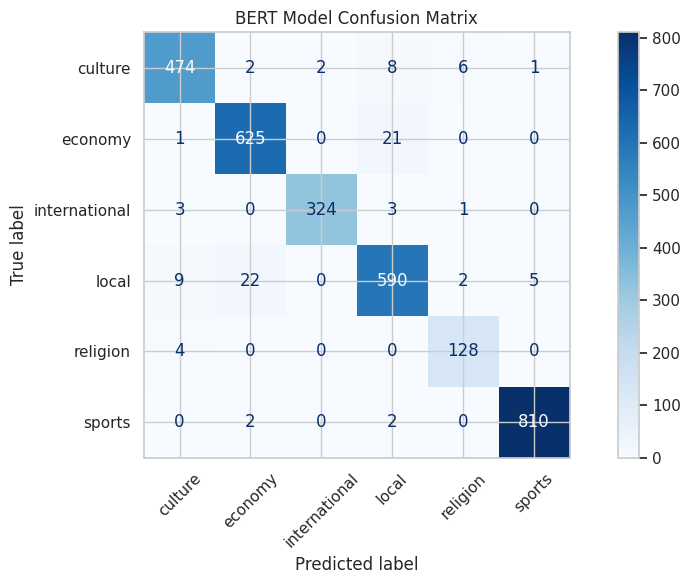

In [ ]:
cm_bert = confusion_matrix(bert_true, bert_preds)
labels = [label_mapping[i] for i in range(len(label_mapping))]
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=labels)

plt.figure(figsize=(10, 8))
disp_bert.plot(cmap="Blues", xticks_rotation=45)
plt.title("BERT Model Confusion Matrix")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

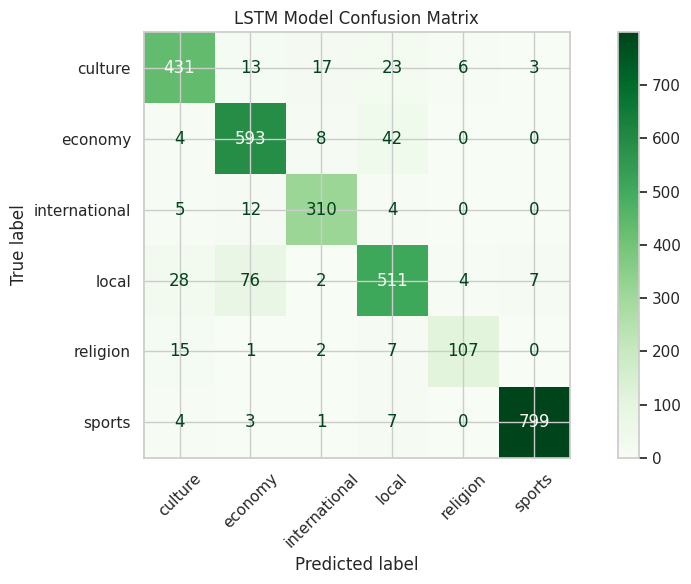

In [ ]:
cm_lstm = confusion_matrix(lstm_true, lstm_preds)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=labels)

plt.figure(figsize=(10, 8))
disp_lstm.plot(cmap="Greens", xticks_rotation=45)
plt.title("LSTM Model Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score


MODEL COMPARISON - CLASSIFICATION ACCURACY
Traditional SVM          : 0.9274
LSTM Neural Network      : 0.8837
BERT Transformer         : 0.9644

Best performing model: BERT Transformer (0.9644)



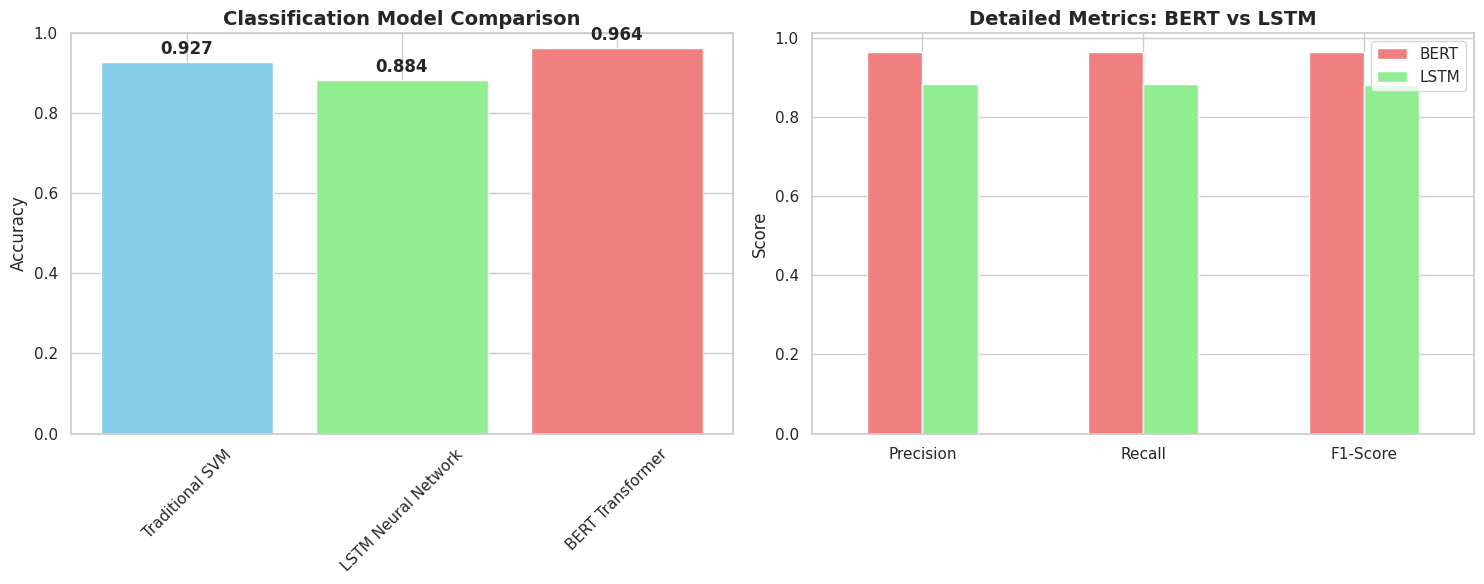

In [ ]:
bert_accuracy = results["eval_accuracy"]


classification_results = {
    "Traditional SVM": svm_accuracy,
    "LSTM Neural Network": lstm_accuracy,
    "BERT Transformer": bert_accuracy,
}

display_model_comparison(classification_results, "Classification Accuracy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models = list(classification_results.keys())
accuracies = list(classification_results.values())
colors = ["skyblue", "lightgreen", "lightcoral"]

ax1.bar(models, accuracies, color=colors)
ax1.set_title("Classification Model Comparison", fontweight="bold", fontsize=14)
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0, 1)
ax1.tick_params(axis="x", rotation=45)

# Add value labels on bars
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontweight="bold")

bert_report = classification_report(
    bert_true, bert_preds, target_names=labels, output_dict=True
)
lstm_report = classification_report(
    lstm_true, lstm_preds, target_names=labels, output_dict=True
)

metrics_comparison = pd.DataFrame(
    {
        "BERT": [
            bert_report["weighted avg"]["precision"],
            bert_report["weighted avg"]["recall"],
            bert_report["weighted avg"]["f1-score"],
        ],
        "LSTM": [
            lstm_report["weighted avg"]["precision"],
            lstm_report["weighted avg"]["recall"],
            lstm_report["weighted avg"]["f1-score"],
        ],
    },
    index=["Precision", "Recall", "F1-Score"],
)

metrics_comparison.plot(kind="bar", ax=ax2, color=["lightcoral", "lightgreen"])
ax2.set_title("Detailed Metrics: BERT vs LSTM", fontweight="bold", fontsize=14)
ax2.set_ylabel("Score")
ax2.tick_params(axis="x", rotation=0)
ax2.legend()

plt.tight_layout()
plt.show()

### Modern Implementation of Task 2

In this section, we implement modern deep learning approaches for Arabic text summarization:

1. **Deep Learning Approach**: LSTM-based Sequence-to-Sequence model with attention
2. **Transformer-based Approach**: Arabic BERT Model

### Seq2Seq Implementation

Sequence-to-sequence model for abstractive Arabic text summarization using encoder-decoder architecture with attention mechanism.

In [ ]:
class ArabicTokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.vocab_built = False

    def clean_arabic_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text)

        text = preprocess_for_summarization(text)

        # Additional cleaning for better tokenization
        text = re.sub(r"[^\u0600-\u06FF\u0750-\u077F\s\d.,!?():\-]", " ", text)
        text = re.sub(r"\s+", " ", text.strip())

        return text

    def build_vocab(self, texts, min_freq=2):
        word_counts = Counter()
        total_words = 0

        for text in tqdm(texts, desc="Processing texts"):
            cleaned = self.clean_arabic_text(text)
            words = cleaned.split()
            word_counts.update(words)
            total_words += len(words)

        print(f"Found {len(word_counts)} unique words from {total_words} total words")

        # Filter by minimum frequency
        filtered_words = {
            word: count
            for word, count in word_counts.items()
            if count >= min_freq and len(word.strip()) > 0
        }

        # Sort by frequency
        most_common = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)

        # Take top words (leave space for special tokens)
        vocab_words = most_common[: self.vocab_size - 4]

        # Add to vocabulary
        for word, count in vocab_words:
            if word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

        self.vocab_built = True

        # Calculate coverage
        covered_tokens = sum(
            count for word, count in word_counts.items() if word in self.word2idx
        )
        token_coverage = covered_tokens / total_words

        print("Vocabulary built:")
        print(f"Final vocabulary size: {len(self.word2idx)}")
        print(f"Token coverage: {token_coverage:.1%}")
        print(f"Top 5 words: {vocab_words[:5]}")

        return token_coverage

    def encode(self, text, max_len, add_special=False):
        cleaned = self.clean_arabic_text(text)
        words = cleaned.split()

        if add_special:
            words = ["<SOS>"] + words + ["<EOS>"]

        indices = []
        for word in words[:max_len]:
            indices.append(self.word2idx.get(word, self.word2idx["<UNK>"]))

        # Pad to max_len
        while len(indices) < max_len:
            indices.append(self.word2idx["<PAD>"])

        return indices[:max_len]

    def decode(self, indices, skip_special=True):
        words = []
        for idx in indices:
            if isinstance(idx, torch.Tensor):
                idx = idx.item()

            word = self.idx2word.get(int(idx), "<UNK>")

            if skip_special:
                if word in ["<PAD>", "<SOS>"]:
                    continue
                elif word == "<EOS>":
                    break

            if word != "<UNK>" or not skip_special:
                words.append(word)

        return " ".join(words)

In [ ]:
split_idx = int(len(summarization_df) * 0.8)
seq2seq_train_df = summarization_df[:split_idx].copy()
seq2seq_test_df = summarization_df[split_idx:].copy()


print(f"  Training samples: {len(seq2seq_train_df)}")
print(f"  Test samples: {len(seq2seq_test_df)}")

  Training samples: 23353
  Test samples: 5839


In [ ]:
# Create tokenizer and build vocabulary
print("\n Building tokenizer vocabulary...")
seq2seq_tokenizer = ArabicTokenizer(vocab_size=10000)

# Use all available text for vocabulary building
all_texts = (
    list(seq2seq_train_df["text"])
    + list(seq2seq_train_df["summary"])
    + list(seq2seq_test_df["text"])
    + list(seq2seq_test_df["summary"])
)

token_coverage = seq2seq_tokenizer.build_vocab(all_texts, min_freq=2)

print("\nTokenizer ready:")
print(f"  Vocabulary size: {len(seq2seq_tokenizer.word2idx)}")
print(f"  Token coverage: {token_coverage:.1%}")


Building tokenizer vocabulary...


Processing texts: 100%|██████████| 58384/58384 [00:15<00:00, 3781.12it/s]


Found 360594 unique words from 10903071 total words
Vocabulary built:
Final vocabulary size: 10000
Token coverage: 79.0%
Top 5 words: [('من', 310035), ('في', 281091), ('على', 249919), ('أو', 174769), ('أن', 162024)]

Tokenizer ready:
Vocabulary size: 10000
Token coverage: 79.0%


In [ ]:
class Seq2SeqSummarizationDataset(Dataset):
    def __init__(self, texts, summaries, tokenizer, max_text_len=100, max_sum_len=25):
        self.texts = texts
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_text_len = max_text_len
        self.max_sum_len = max_sum_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        summary = str(self.summaries[idx])

        src = torch.tensor(
            self.tokenizer.encode(text, self.max_text_len, add_special=False),
            dtype=torch.long,
        )

        # Encode summary with special tokens for decoder
        tgt_with_special = self.tokenizer.encode(
            summary, self.max_sum_len - 1, add_special=True
        )

        # Decoder input: <SOS> + summary (without last token)
        tgt_input = torch.tensor(tgt_with_special[:-1], dtype=torch.long)

        # Decoder target: summary + <EOS> (without first token)
        tgt_output = torch.tensor(tgt_with_special[1:], dtype=torch.long)

        # Ensure proper lengths
        if len(tgt_input) < self.max_sum_len:
            pad_len = self.max_sum_len - len(tgt_input)
            tgt_input = torch.cat([tgt_input, torch.zeros(pad_len, dtype=torch.long)])
            tgt_output = torch.cat([tgt_output, torch.zeros(pad_len, dtype=torch.long)])

        return src, tgt_input[: self.max_sum_len], tgt_output[: self.max_sum_len]


seq2seq_train_dataset = Seq2SeqSummarizationDataset(
    seq2seq_train_df["text"].tolist(),
    seq2seq_train_df["summary"].tolist(),
    seq2seq_tokenizer,
    MAX_TEXT_LEN,
    MAX_SUM_LEN,
)

seq2seq_test_dataset = Seq2SeqSummarizationDataset(
    seq2seq_test_df["text"].tolist(),
    seq2seq_test_df["summary"].tolist(),
    seq2seq_tokenizer,
    MAX_TEXT_LEN,
    MAX_SUM_LEN,
)

seq2seq_train_loader = DataLoader(
    seq2seq_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
seq2seq_test_loader = DataLoader(
    seq2seq_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)


print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max text length: {MAX_TEXT_LEN}")
print(f"  Max summary length: {MAX_SUM_LEN}")
print()


sample_src, sample_tgt_in, sample_tgt_out = seq2seq_train_dataset[0]

print(f"Decoded source: {seq2seq_tokenizer.decode(sample_src)[:300]}...")
print()
print(f"Decoded target: {seq2seq_tokenizer.decode(sample_tgt_out)}")

  Batch size: 32
  Max text length: 500
  Max summary length: 50

Decoded source: يكون سعر الفاكهة والخضراوات في موسم أقل من غيره من محلات الخضروات إلى عرض الفاكهة مناسبة في بسبب توفر المنتجات وزيادة الطلب عليها خلال تلك لا يقتصر الأمر على السعر الأقل، بل سيكون طعامك من الخضراوات والفاكهة عند تناوله في في فصل التفاح في فصل والبصل البطاطا الحلوة في فصل السبانخ والجزر والبصل الأخضر...

Decoded target: تناول الفاكهة والخضراوات في تعرف على أسعار الأطعمة المجمدة تابع العروض في المحلات دائما ما بين اشتر استفد من الشراء استفد من الجهات الدخل في بلدك. اشتر من المحلية أو المتاجر


#### Model Architecture

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, dropout=0.2):
        super(Seq2Seq, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim

        # Encoder
        self.encoder_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.encoder_lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            dropout=dropout if dropout > 0 else 0,
        )

        # Decoder
        self.decoder_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.decoder_lstm = nn.LSTM(
            embed_dim + hidden_dim,
            hidden_dim,
            batch_first=True,
            dropout=dropout if dropout > 0 else 0,
        )

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim)
        self.context_combine = nn.Linear(hidden_dim * 2, hidden_dim)

        # Output projection
        self.output_proj = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def encode(self, src):
        embedded = self.encoder_embedding(src)
        embedded = self.dropout(embedded)

        outputs, (hidden, cell) = self.encoder_lstm(embedded)
        return outputs, hidden, cell

    def attention_forward(self, decoder_hidden, encoder_outputs):
        # Reshape decoder hidden
        if decoder_hidden.dim() == 3:
            decoder_hidden = decoder_hidden[-1].unsqueeze(1)  # Take last layer
        elif decoder_hidden.dim() == 2:
            decoder_hidden = decoder_hidden.unsqueeze(1)

        # Calculate attention scores
        scores = torch.bmm(decoder_hidden, encoder_outputs.transpose(1, 2))
        attention_weights = torch.softmax(scores, dim=2)

        # Apply attention
        context = torch.bmm(attention_weights, encoder_outputs)
        return context, attention_weights

    def forward(self, src, tgt):
        batch_size, tgt_len = tgt.size()

        # Encode
        encoder_outputs, hidden, cell = self.encode(src)

        # Initialize decoder
        decoder_hidden = hidden
        decoder_cell = cell
        outputs = torch.zeros(batch_size, tgt_len, self.vocab_size).to(src.device)

        for t in range(tgt_len):
            # Get current target token
            current_input = tgt[:, t : t + 1]

            # Embed current token
            embedded = self.decoder_embedding(current_input)
            embedded = self.dropout(embedded)

            # Apply attention
            context, _ = self.attention_forward(decoder_hidden, encoder_outputs)

            # Combine embedding with context
            lstm_input = torch.cat([embedded, context], dim=2)

            # LSTM step
            output, (decoder_hidden, decoder_cell) = self.decoder_lstm(
                lstm_input, (decoder_hidden, decoder_cell)
            )

            # Project to vocabulary
            vocab_dist = self.output_proj(output)
            outputs[:, t : t + 1] = vocab_dist

        return outputs

    def generate(self, src, max_len=25, temperature=0.8):
        self.eval()
        with torch.no_grad():
            batch_size = src.size(0)

            # Encode
            encoder_outputs, hidden, cell = self.encode(src)

            # Initialize decoder
            decoder_hidden = hidden
            decoder_cell = cell

            # Start with <SOS> token
            current_input = torch.ones(batch_size, 1, dtype=torch.long).to(src.device)

            generated = []

            for _ in range(max_len):
                # Embed current token
                embedded = self.decoder_embedding(current_input)

                # Apply attention
                context, _ = self.attention_forward(decoder_hidden, encoder_outputs)

                # Combine embedding with context
                lstm_input = torch.cat([embedded, context], dim=2)

                # LSTM step
                output, (decoder_hidden, decoder_cell) = self.decoder_lstm(
                    lstm_input, (decoder_hidden, decoder_cell)
                )

                # Project to vocabulary
                vocab_dist = self.output_proj(output)

                # Apply temperature
                vocab_dist = vocab_dist / temperature

                # Sample next token
                probs = torch.softmax(vocab_dist, dim=2)
                next_token = torch.multinomial(probs.squeeze(1), 1)

                generated.append(next_token)
                current_input = next_token

                if (next_token == 2).all():
                    break

            return torch.cat(generated, dim=1)


VOCAB_SIZE = len(seq2seq_tokenizer.word2idx)
seq2seq_model = Seq2Seq(
    vocab_size=VOCAB_SIZE, embed_dim=128, hidden_dim=256, dropout=0.2
).to(device)

# Count parameters
total_params = sum(p.numel() for p in seq2seq_model.parameters())

print(f"  Total parameters: {total_params:,}")
print(f"  Vocabulary size: {VOCAB_SIZE}")
print(f"  Device: {device}")


seq2seq_criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
seq2seq_optimizer = optim.Adam(seq2seq_model.parameters(), lr=0.001)

  Total parameters: 6,445,328
  Vocabulary size: 10000
  Device: cuda


#### Training and Optimization

In [ ]:
def train_seq2seq_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    num_batches = 0

    pbar = tqdm(dataloader, desc="Training Seq2Seq")
    for batch_idx, (src, tgt_input, tgt_output) in enumerate(pbar):
        src, tgt_input, tgt_output = (
            src.to(device),
            tgt_input.to(device),
            tgt_output.to(device),
        )

        optimizer.zero_grad()

        # Forward pass
        outputs = model(src, tgt_input)

        # Calculate loss
        loss = criterion(
            outputs.contiguous().view(-1, VOCAB_SIZE), tgt_output.contiguous().view(-1)
        )

        # Backward pass
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        if batch_idx % 10 == 0:
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return total_loss / num_batches


def eval_seq2seq_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for src, tgt_input, tgt_output in dataloader:
            src, tgt_input, tgt_output = (
                src.to(device),
                tgt_input.to(device),
                tgt_output.to(device),
            )
            outputs = model(src, tgt_input)
            loss = criterion(
                outputs.contiguous().view(-1, VOCAB_SIZE),
                tgt_output.contiguous().view(-1),
            )
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

In [ ]:
EPOCHS = 5
print(f"Starting Seq2Seq training for {EPOCHS} epochs...")

# Training loop
seq2seq_train_losses = []
best_loss = float("inf")

for epoch in range(EPOCHS):
    avg_loss = train_seq2seq_epoch(
        seq2seq_model,
        seq2seq_train_loader,
        seq2seq_optimizer,
        seq2seq_criterion,
        device,
    )
    seq2seq_train_losses.append(avg_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {avg_loss:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": seq2seq_model.state_dict(),
                "optimizer_state_dict": seq2seq_optimizer.state_dict(),
                "loss": avg_loss,
            },
            "best_seq2seq_model.pt",
        )
        print(f"New best model saved (loss: {avg_loss:.4f})")

    # Early stopping if loss is very low
    if avg_loss < 0.1:
        print("Loss is very low, stopping early!")
        break

print("Seq2Seq training completed!")

Starting Seq2Seq training for 5 epochs...


Training Seq2Seq: 100%|██████████| 730/730 [02:52<00:00,  4.24it/s, loss=5.2955]


Epoch 1/5 - Loss: 5.8243
New best model saved (loss: 5.8243)


Training Seq2Seq: 100%|██████████| 730/730 [02:42<00:00,  4.50it/s, loss=5.1634]


Epoch 2/5 - Loss: 5.1640
New best model saved (loss: 5.1640)


Training Seq2Seq: 100%|██████████| 730/730 [02:43<00:00,  4.48it/s, loss=4.8693]


Epoch 3/5 - Loss: 4.7813
New best model saved (loss: 4.7813)


Training Seq2Seq: 100%|██████████| 730/730 [02:43<00:00,  4.45it/s, loss=4.3128]


Epoch 4/5 - Loss: 4.5234
New best model saved (loss: 4.5234)


Training Seq2Seq: 100%|██████████| 730/730 [02:44<00:00,  4.45it/s, loss=4.3476]


Epoch 5/5 - Loss: 4.3359
New best model saved (loss: 4.3359)
Seq2Seq training completed!


#### Evaluation and Results

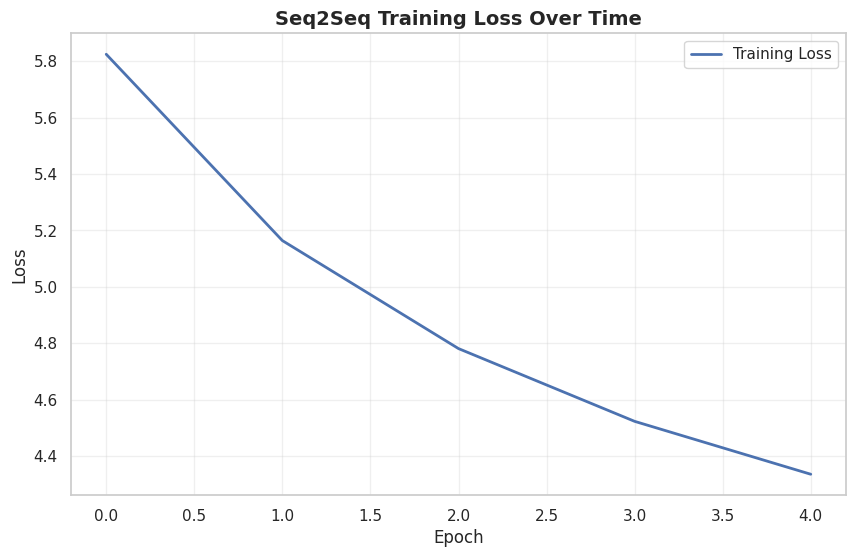

Final training loss: 4.3359
Best training loss: 4.3359


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(seq2seq_train_losses, "b-", linewidth=2, label="Training Loss")
plt.title("Seq2Seq Training Loss Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final training loss: {seq2seq_train_losses[-1]:.4f}")
print(f"Best training loss: {min(seq2seq_train_losses):.4f}")

In [ ]:
def generate_seq2seq_summaries(model, test_dataset, tokenizer, num_samples=5):
    model.eval()
    results = []

    for i in range(min(num_samples, len(test_dataset))):
        src, _, tgt_out = test_dataset[i]
        src = src.unsqueeze(0).to(device)

        generated = model.generate(src, max_len=MAX_SUM_LEN, temperature=0.7)

        original_text = tokenizer.decode(src.squeeze().cpu())
        reference_summary = seq2seq_test_df["summary"].iloc[i]
        generated_summary = tokenizer.decode(generated.squeeze().cpu())

        results.append(
            {
                "original": original_text,
                "reference": reference_summary,
                "generated": generated_summary,
            }
        )

        print(f"\n--- Example {i + 1} ---")
        display(f" Original: {original_text}...")
        print()
        display(f" Reference: {reference_summary}")
        print()
        display(f" Generated: {generated_summary}")
        print("-" * 60)

    return results


def calculate_bleu_rouge_scores(results):
    bleu_scores = []
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=False)

    for result in results:
        reference = result["reference"]
        generated = result["generated"]

        # BLEU score (sentence-level)
        if reference and generated:
            # Simple BLEU calculation
            ref_words = reference.split()
            gen_words = generated.split()

            if len(gen_words) > 0 and len(ref_words) > 0:
                # Calculate simple overlap-based score
                overlap = len(set(ref_words).intersection(set(gen_words)))
                precision = overlap / len(gen_words)
                recall = overlap / len(ref_words)
                f1 = (
                    2 * precision * recall / (precision + recall)
                    if (precision + recall) > 0
                    else 0
                )
                bleu_scores.append(f1)
            else:
                bleu_scores.append(0.0)

            # ROUGE scores
            try:
                rouge_result = scorer.score(reference, generated)
                rouge_scores["rouge1"].append(rouge_result["rouge1"].fmeasure)
                rouge_scores["rouge2"].append(rouge_result["rouge2"].fmeasure)
                rouge_scores["rougeL"].append(rouge_result["rougeL"].fmeasure)
            except:
                rouge_scores["rouge1"].append(0.0)
                rouge_scores["rouge2"].append(0.0)
                rouge_scores["rougeL"].append(0.0)
        else:
            bleu_scores.append(0.0)
            rouge_scores["rouge1"].append(0.0)
            rouge_scores["rouge2"].append(0.0)
            rouge_scores["rougeL"].append(0.0)

    return {
        "bleu": np.mean(bleu_scores),
        "rouge1": np.mean(rouge_scores["rouge1"]),
        "rouge2": np.mean(rouge_scores["rouge2"]),
        "rougeL": np.mean(rouge_scores["rougeL"]),
    }


# Load best model
try:
    checkpoint = torch.load("best_seq2seq_model.pt", map_location=device)
    seq2seq_model.load_state_dict(checkpoint["model_state_dict"])

except:
    print("Using current model state")

# Generate summaries
seq2seq_results = generate_seq2seq_summaries(
    seq2seq_model, seq2seq_test_dataset, seq2seq_tokenizer, num_samples=10
)


--- Example 1 ---


' Original: إذا كان الهيكل يساعدك في فترة أعراض الانسحاب الأولية فقد يساعدك أيضا في على المدى البعيد. عدل جدولك عند الضرورة ولكن مع الإبقاء على العادات الجيدة التي بالفعل. تأكد من أنك تتحكم في أي دواء وكذلك الذهاب بانتظام لا تتوقف عن الاستفادة من مميزات هذه المصادر فقط لكونك تشعر لأن التعافي من الإدمان عملية طويلة على تفقد الأمر مع طبيبك أو المعالج أو مجموعة الدعم. إذا أصبح الأمر أو ابدأ في التفكير به الطعام الصحي أو أداء التمارين الرياضية، فهي أشياء تفعلها بانتظام للبقاء في صحة جيدة حتى حينما لا تريد ذلك. فكر في أن الباقي من حياتك يمكن أن يكون لذا توقف على نحو دوري مثل بدون تعاطي أشهر بعد مرور يوم واحد أو أسبوع من بعيدا عن يمكنك مكافأة نفسك بشيء تستمتع به مثل عشاء لطيف أو رحلة ركز على ما فعلته بشكل جيد لكي تضع أهدافا التالي. بعد شهر من يمكنك أن حفلة نظيفة خالية من الكحول كون صداقات صحية شخصية أقوى الذي على البدء في قضاء الوقت مع أشخاص استخدام يمكنك وضع حدود معينة مع الأفراد الذين بقول أنا على في مرحلة من لذا لا يمكنني أن أكون يستخدمون إنها كبيرة بالنسبة لي في لذلك. كون علاقات جديدة مع

' Reference: استمر في الالتزام بروتينك اليومي. تشبث ببرنامجك الاستشاري أو مجموعة الدعم. احتفل بالإنجازات الهامة. أحط نفسك بأناس جيدين. راقب العلامات التحذيرية.'

' Generated: حدد موعدا مع طبيبك بشأن البثور. تجنب شرب الكحول في نفس الوقت. اسأل عن الأصدقاء الذين'

------------------------------------------------------------

--- Example 2 ---


' Original: حينما تتوقف عن أخذ قد تتعرض وكذلك تعاني من رغبة شديدة في استعد لهذه المشكلات بإعداد بيئة آمنة ستحتاج في مكان لا يتوافر به ولا يمكنك كذلك الوصول له بسهولة ولا يتواجد أيا من الأصدقاء أو الذين فكر في اختيار تغيير كبير في فإذا كان ممكنا أن تذهب أو أحد بدلا من البقاء في فمن الأسهل كسر دائرة الإدمان إن كنت في بيئة غير عليها. فكر في الذهاب علاج الإدمان أو إعادة أعرف من يمكنه مساعدتك وقت من أعراض الانسحاب الأطباء ضمن هذه الفئة وكذلك أعضاء المجموعات طالما لا يستخدم أيا من هؤلاء قد يكون من المفيد كتابة قائمة الذين يمكنك الاتصال بهم خلال مرحلة التخلص من على حصولك على رقم وكذلك طرق الاتصال بالطبيب أقرب لك. بينما جسمك على غياب سوف تتعرض وتكون في أشد خلال ال ساعة الأولى، وبعدها الأعراض تدريجيا خلال - أسابيع. تتضمن أعراض الانسحاب الشائعة ما يلي: زيادة في النوم وتناول الطعام ومشاكل في التركيز والقلق المزعجة الشديد توقع حدوث أعراض الانسحاب السابق وحاول تغييرات إيجابية بالتفكير فيها أثناء تنقية من وينبغي للوصول إلى الجانب وأنا قوي كفاية لتحقيق ذلك . إن كنت تعمل مع طبيب أو مركز اسأل عن الأدوي

' Reference: تحكم في بيئتك المحيطة. حدد الأشخاص الذين يمكنهم مساعدتك. توقع أعراض الانسحاب واستعد لها. فكر في الاستعانة بالأدوية للتغلب على أعراض الانسحاب. تشبث بروتين يومي. واجه التوق الشديد للعقار. ركز على عادات جديدة.'

' Generated: قم على عضلاتك احرص على قم بزيارة طبيبك إذا كانت مصابا'

------------------------------------------------------------

--- Example 3 ---


' Original: هناك العديد من التي قد ترغب في والتي تتيح جميعها إطلاق شيوعا هو في صندوق بحيث يمكنه الدخول لكن ليس الخروج. هذه من الطرق في سيكون عليك على بعد خمسة كيلو على الأقل من منزلك عند ربما في منطقة الأشجار مكانا آخر يعيشون فيه. لن يحل قتل أو إبعاد المشكلة تماما ولن لفترة طويلة. عند قتل الحيوانات أو المزيد لاستخدام الموارد وفي الواقع فإن قتل الفئران قد يسبب مؤقتا في مصادر الغذاء مما ينتج باقي ورغم ذلك، لا يزال من الأفضل تقليل العدد بدلا من لها. استخدم وعاء اقلب الوعاء الكبير مع وضع بعض الشوكولاتة حافظ على بزاوية مائلة مع وضع العملة على الحافة العملة مع حافة ثم اتركه في مكان أسفل الوعاء الوصول في الأعلى ما الوعاء خذ لمكان بعيد عن المنزل. يمكنك استخدام حوض سمك بحجم كبير يزيد عن لتر مثلا مع وضع بعض الطعام ضع الحوض في مكان سبق لك رؤية فيه في مكان طريق ضع شيئا بجوار الحوض يسهل على مثل كومة من من المفترض أن يحاول الوصول للطعام إلى الحوض، وبعد يصبح تفقد بانتظام. ضع غطاء على الحوض إذا وجدت بعيدا عن المنزل. لوقت قصير لذا تصرف بسرعة. ضع سلة على ثم قم بإدخال أطراف المنشفة تحت السلة بحيث تكون عل

' Reference: جرب المصائد التجارية. اصنع فخا رحيما. قم بإغواء الفأر لدخول حاوية لا يستطيع الخروج منها. ألق منشفة على الفأر.'

' Generated: تفقد ارتد أزل'

------------------------------------------------------------

--- Example 4 ---


' Original: كثيرا ما الفئران بحثا عن الطعام وعلى الأرجح لن تبقى إذا لم تجد شيئا احرص على تخزين الأطعمة في محكمة أو أماكن آمنة من زيت النعناع هو طارد ببساطة لأن رائحته جدا بالنسبة ولن الاقتراب منها. كذلك تغطي على رائحته روائح الطعام التي ربما لم تنتبه لها عند التنظيف كما أنها تعطي رائحة جميلة للمنزل وهي غير سامة على عكس كثير من العلاجات الكيميائية يمكنك الحصول على زيت النعناع من معظم متاجر الأطعمة الصحية أو بعض متاجر الخضراوات الكبيرة. ضع نقطة أو اثنتين على كرة من ضع الكرة القطنية أسفل أو بالقرب من سلة القمامة لطرد الفئران من الدخول إليها. ضع الكرات القطنية في أماكن دخول الفئران مثل الأبواب أو فتحات ... يجب استبدال كرات زيت النعناع القطنية بعد - أيام، على حسب كمية الزيت التي قمت حاول زرع النعناع قرب يمكن استخدام النعناع في الطبخ بالإضافة لاستخدامه قم بزيارة مركز المحلي أو حديقة الحيوان أو متاجر الحيوانات الأليفة واطلب بعض فضلات قد تجد شخصا يقوم ضعه بالقرب من والأماكن التي في دخول الفئران إليها، فهذا احرص على إبعاد هذه الفضلات عن متناول الأطفال والحيوانات الأليفة. هنالك وحدات تباع وتقوم 

' Reference: حافظ على نظافة منزلك. ضع زيت النعناع. استخدم براز الأفاعي المجفف. اطرد الفئران بالموجات فوق الصوتية. استخدم طاردا عضويا تجاريا. أحضر قطة وقد تتكفل هي بحل المشكلة. ضع حاوية القمامة بعيدا عن المنزل. اعمل على زيادة تعشيش الطيور الجارحة في باحتك.'

' Generated: حدد ما إذا كان استخدم بدائل إذا كان استخدام انقل الملكية من'

------------------------------------------------------------

--- Example 5 ---


' Original: أحيانا تكون هنالك دهنية وغالبا الطعام قرب بالإضافة لوجود رائحة حدد البقعة بمادة ملونة إذا كان إيجادها صعبا حتى تتمكن من العودة لها بسهولة. ابدأ الداخلية لأنه من الأفضل دائما ترك قد منزلك أو بحثا عن فضلات أسهل في مكان آخر. استخدم مادة ملونة أو عجينة من الجبس مثلا الفتحات الصغيرة نسبيا. ستحتاج إلى استخدام الشريط اللاصق على الجدار في حالة الفتحات الكبيرة والتي لا يمكن أو هذا عمل أكبر لكنه مهم إذ أن يستطيع بالتأكيد عبر الفتحات الكبيرة. تأكد من الألواح وعدم وجود فيها، حتى تمنع الفئران قد تقوم الفئران جديدة إذا بين لذا من المهم فرصة للخروج قبل سد نقطة الدخول الخارجية. ينصح عادة الفتحات بالألياف لكنها ولذا لا تعد حلا دائما، بدلا من ذلك استخدم المطبخ الصحيح أو استخدم تنظيف مع تغطية جوانب الفتحة وإلا الفتحات الأكبر ستحتاج إلى قم أية فتحات في من الخارج بعد من إغلاق الفتحات في الجدران الداخلية. قد تستخدم تنظيف لكن في بعض الحالات تكون الجدران بحاجة أخرى. ابحث عن أي دليل على استمرار نشاط الفئران بعد يومين. تفقد الفتحات التي قمت وابحث عن فتحات أخرى إذا وجدت أيا منها. قم حسب الحاجة. قم بت

' Reference: جد مكان دخول الفئران. قم بسد أية فتحات في الجدران الداخلية. قم بسد نقاط الدخول الخارجية. تفقد نقط الدخول مجددا.'

' Generated: قم إلى درجة حرارة درجة مئوية. اقطع أضف الماء في ماء جرب تدريب'

------------------------------------------------------------

--- Example 6 ---


' Original: تأكد قبل وضع أي شيء في المرحاض ألا ضرر من ذلك. قائمة الأشياء التي لا بأس في المرحاض قصيرة جدا وهي تشمل في معظم الحالات الفضلات البشرية الحمام فقط. لا تحاول أبدا التخلص من المناشف أو المناديل الورقية أو المكياج أو السدادات أو الواقي الذكري أو أو الشعر أو أي مواد أخرى لا تذوب بسهولة بعد الطريقة لنفسك المشاكل عمليات في وقت لاحق. هي السبب الرئيسي في المنازل التي تضم أبق باب الحمام إذا كان لديك أطفال واحرص أن أنه ليس مكانا مناسبا ضع سلة صغيرة بغطاء قرب المرحاض حتى يسعك أنت أو ما لا يمكن سيكون من غير الآمن غالبا طرد شيء ما في المرحاض إذا في تحدث معظم نتيجة تراكم المناديل الورقية الزائدة التي تعلق في قبل أن يتاح لها الوقت اللازم انتبه المناديل بانتظام وتأكد أنك تستخدم القدر الضروري فقط حاول استخدام حمام مختلف من آن لآخر إذا كان بيتك يحتوي أكثر من واحد حتى لا تشغل أكثر مما ضع في اعتبارك طرد الماء مرتين إذا ظننت أن مرة واحدة لا فليس ثمة حاجة لاستخدام نصف المناديل في كل مرة تحتاج ضع في اعتبارك الانتقال إلى المناديل ذات الطبقة الواحدة إذا كنت تواجه مشاكل الانسداد قد لا تكون بنفس درجة 

' Reference: لا تضع في المرحاض سوى الأشياء القابلة للذوبان. قلل مقدار المناديل الورقية التي تستخدمها. حدد المشكلة باكرا. حافظ على نظافة الحمام والمواسير.'

' Generated: حضر السلامة عن حدد أنواع على الفم.'

------------------------------------------------------------

--- Example 7 ---


' Original: ضع بعض المناديل أو لحماية الأرضية فمن المحتمل أن الماء من المرحاض مع عمل على سيكون هذا الماء سبب الانسداد أيا كان في يمكن لتغطية الأرضية أن التعامل مع مزيد من الفوضى لاحقا . اغسل المستخدمة على الفور بعد الانتهاء وامسح الأرض بمحلول سيصبح الوضع في الغالب لذا ارتد لوضع حاجز بين جلدك التي قد تجدها على الطرف الآخر من أيا مليئة وإذا لم تتخذ اللازمة لحماية يديك والحفاظ على فستكون النتيجة إصابتك تخلص من حين تنتهي واغسل يديك لدقيقة كاملة بالصابون المضاد للبكتيريا والماء الساخن. سيكون عليك إزالة السلك لا تنس رفع أثناء العمل كي لا لقد نجحت في استخراج ما لكن ماذا به الآن؟ ضع كيس أو قريبا منك وضع المادة المسببة به بدل محاولة الماء عليها مجددا مشكلة جديدة، يمكنك بهذه الطريقة الكيس في القمامة أو شطف الدلو جيدا يومك. يعتبر كيس البقالة البلاستيكي وسيلة مثالية للتخلص من اربط الكيس بعد وضع المادة المزعجة في استخدم في المرحاض بضع مرات بعد إتمام المهمة للتخلص من أي بقايا ثم اسكب بعضا من منظف المركز وقم الماء مرتين. الكيماويات الموجودة في تنظيف قوية بما يكفي ما تبقى في كما أن المرحاض من النظافة 

' Reference: غط أرضية المرحاض. ارتد القفازات. جهز كيس قمامة أو غيره من الأوعية. اسكب منظف المراحيض وقم بدفق الماء في الأنابيب.'

' Generated: ابحث عن الضغط أزل الزائدة الطيور'

------------------------------------------------------------

--- Example 8 ---


' Original: قم الطرف المعدني في المرحاض. ابدأ إدخال السلك في هناك في طرف والذي يساعد في الكتل في تأكد من سلامة الغطاء البلاستيكي الموجود في نهاية حتى لا اللاصق إذا لم يكن يجب ألا يكون الكابل إذا كان كل شيء كما ابدأ بلف مقبض الطرف الآخر بمعدل ثابت بعد وضع مكانه فهذا السلك ببطء في تصنع هذه الأدوات من ملفات معدنية مرنة حتى يمكن مع اسحب للخلف قليلا إذا لم المقبض ربع عكس اتجاه عقارب الساعة وحاول مرة أخرى. قد يكون انسداد المرحاض ببساطة لف المقبض بضع مرات. لعلك وجدت مقاومة إذا لاحظت أن أبطأ أو على ادفع قليلا لتساعد في ما يعلق في واصل لف المقبض مع حركة عقارب الساعة حتى لا تكن مع عصا ولا تحاول سحب الكتلة تابع في الاتجاه واتركه الانسداد بنفسه. لف المقبض في الاتجاه عقارب لسحب بعد تحديد مكان الانسداد والعمل عليه ما قد اسحب الكتلة دوما بدلا من محاولة أكثر في كرر هذه العملية حتى الأنبوب بالكامل. قد يؤدي دفع الانسداد أكثر إلى تفاقم سوء المشكلة لأنه قد يصل لا يسعك احرص دوما على تطهير بعد كل استخدام ويمكن تحقيق هذا خارج البيت كما يمكنك ترك في المرحاض الماء بضع مرات بعد استخدام منظف المرحاض....'

' Reference: ضع طرف الأوجير في المرحاض. لف المقبض الملتوي مع حركة عقارب الساعة. تحسس الانسداد في المواسير. فتت الانسداد أو تخلص من أكبر قدر ممكن منه.'

' Generated: املأ اقطع طبقة في في استخدم البذور. ارسم خطا ارسم خطا في إطار ارسم'

------------------------------------------------------------

--- Example 9 ---


' Original: يجب أن تكون إلى بعضها البعض لتبدأ ضع يدك في الماء، الأصابع أولا فوق رأسك بحوالي سم تقريبا. يجب أن تكون راحة يدك بزاوية للخارج بحيث تدخل في الماء أولا، وأن يكون لأسفل فوق الأصابع فوق يجب أن تسبب يدك الماء قدر الإمكان عند لذا قم ذراعك مسافة سم إضافية. اضغط يدك للأسفل بمجرد الماء مع أصابعك قليلا. يسمى هذا الماء أو . يمكنك ارتداء الماء لتساعدك على التركيز على كيفية دخول يدك من الماء إذا أردت أن تحسن أسلوب يدك. تجنب وضع يدك في الماء فوق رأسك مباشرة، لأن هذا هذا لا تضرب الماء بقوة ولكن دخول يدك الماء ذراعك فيه بدلا من ذلك. لا تتحرك ذراعك للأمام أثناء التخلص لكنها توفر الدعم الذي يقوم تحت الماء. من المهم أن تعمل على أسلوب التخلص لتضمن أن يكون وضع يدك جيدا. مد يدك للأمام كتفك خارج الماء لإنهاء الحركة حيث يجب أن تكون أصابعك فوق الماء وأن يدك بدرجة أوسع من يجب أن يكون ذراعك الحركة أيضا. ركز على إدارة ذراعك للأمام ولا للأسفل بالقوة في نهاية الخروج....'

' Reference: اجعل وضع يدك وحالتها مثاليا. حرك مرفقك خارج الماء مظهرا التخلص.'

' Generated: ضع محلول في حوض المياه. ضع داخل المنزل.'

------------------------------------------------------------

--- Example 10 ---


' Original: تتطلب قوة أقل المسافات المتوسطة إنك واحدة لكل دورة حركة دورة الحركة حركة ذراع واحد. واحدة مع المسح الداخلي المقابل الداخلي هو الذي يبدأ فيه الذراع بسحب الماء تجاه الجزء الأوسط من يمكنك تخيل الكيفية التي يجب مع حركة ذراعك بها إذا كان يمكنك التفكير في توافق ذراعيك أثناء المشي أو كيفية تحرك ذراعيك للأمام في ذات الوقت مع الرجل تتطلب أن ثلاث مرات لكل دورة ستبدأ الثالثة من دورة خلال طور التعافي وهذه أسرع يستخدمها سيكون هناك إضافية الجزء الأمامي من قدميك إذا لم تكن موجهة أثناء يجب أن أصابع قدميك للداخل وأن يقترب من التلامس عندما تمرن على مرونة عند إبراز أصابع قدميك وضع في اعتبارك استخدام حذاء للتدرب على إذا كنت تجد صعوبة في مرونة يمكنك التركيز على كل من أساليب الذراع في السباحة الحرة بسهولة أكبر الإضافي الذي لكن استخدمها فقط لتدريب قدميك أثناء التمارين....'

' Reference: استخدم ركلة الضربتين. وجه أصابع قدميك أثناء الركل.'

' Generated: حافظ على جرب العلاج ارتد ملابس من'

------------------------------------------------------------


In [ ]:
# Calculate evaluation metrics
seq2seq_scores = calculate_bleu_rouge_scores(seq2seq_results)

print(f"Seq2Seq Model Evaluation Results:")
print(f"{'=' * 50}")
print(f"  BLEU Score: {seq2seq_scores['bleu']:.3f}")
print(f"  ROUGE-1 F1: {seq2seq_scores['rouge1']:.3f}")
print(f"  ROUGE-2 F1: {seq2seq_scores['rouge2']:.3f}")
print(f"  ROUGE-L F1: {seq2seq_scores['rougeL']:.3f}")

Seq2Seq Model Evaluation Results:
  BLEU Score: 0.045
  ROUGE-1 F1: 0.054
  ROUGE-2 F1: 0.000
  ROUGE-L F1: 0.054


### BERT Implementation

BERT-based extractive summarization using AraBERT for sentence embedding similarity and automatic text summarization.

In [ ]:
class BERTExtractiveSum:
    def __init__(self, model_name="asafaya/bert-base-arabic"):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.device = device
        self.model.to(self.device)

    def get_sentence_embeddings(self, sentences):
        embeddings = []

        self.model.eval()
        with torch.no_grad():
            for sentence in sentences:
                # Tokenize
                inputs = self.tokenizer(
                    sentence,
                    return_tensors="pt",
                    max_length=512,
                    truncation=True,
                    padding=True,
                ).to(self.device)

                # Get embeddings
                outputs = self.model(**inputs)

                embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(embedding.squeeze())

        return np.array(embeddings)

    def extractive_summarize(self, text, num_sentences=2):
        # Split into sentences
        sentences = re.split(r"[.!؟\n]+", text)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 10]

        if len(sentences) <= num_sentences:
            return text

        # Get sentence embeddings
        sentence_embeddings = self.get_sentence_embeddings(sentences)

        # Calculate document embedding (mean of all sentences)
        doc_embedding = np.mean(sentence_embeddings, axis=0)

        # Calculate similarity scores
        similarities = cosine_similarity([doc_embedding], sentence_embeddings)[0]

        # Get top sentences
        top_indices = np.argsort(similarities)[-num_sentences:][::-1]

        # Return sentences in original order
        selected_sentences = [sentences[i] for i in sorted(top_indices)]

        return " ".join(selected_sentences)

#### Model Initialization and Configuration

In [ ]:
bert_sum_model_path = os.path.join(MODEL_SAVE_DIR, "bert_summarization_model")

if os.path.exists(bert_sum_model_path):
    print("Loading existing BERT summarization model...")
    try:
        bert_summarizer = BERTExtractiveSum()
        bert_summarizer.model = BertModel.from_pretrained(bert_sum_model_path).to(
            device
        )
        bert_summarizer.tokenizer = BertTokenizer.from_pretrained(bert_sum_model_path)
        print("✓ Loaded existing BERT summarization model")
    except:
        print("Failed to load existing model, initializing new one...")
        bert_summarizer = BERTExtractiveSum()
else:
    bert_summarizer = BERTExtractiveSum()
    # Save the model
    bert_summarizer.model.save_pretrained(bert_sum_model_path)
    bert_summarizer.tokenizer.save_pretrained(bert_sum_model_path)
    print(f"✓ BERT summarization model saved to {bert_sum_model_path}")

Initializing BERT summarization model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

✓ BERT summarization model saved to ./saved_models/bert_summarization_model


#### Evaluation and Performance Analysis

In [ ]:
bert_summaries = []
for text in tqdm(X_sum_test, desc="BERT Summarization"):
    try:
        summary = bert_summarizer.extractive_summarize(text, num_sentences=2)
        bert_summaries.append(summary)
    except Exception as e:
        print(f"Error generating summary: {e}")
        bert_summaries.append("")

BERT Summarization: 100%|██████████| 5839/5839 [18:39<00:00,  5.22it/s]


In [ ]:
display(bert_summarizer.extractive_summarize(X_sum_test[1], num_sentences=2))

'ماسحات الزجاج الأمامي مصممة لاتباع حركة ذراع الماسحة، لذلك إذا كانت الشفرات متصلبة ولا تتحرك خلف الذراع ذهابا وإيابا، لف الذراع بيدك لترخية صلابتها تسبب شفرات الماسحة الخشنة صوت حكة وصرير وقد تكون بعض شفرات الماسحة الجديدة خشنة منذ البداية، بينما قد تصبح أخرى خشنة نتيجة التعرض للعناصر المختلفة'

In [ ]:
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
scorer = rouge_scorer.RougeScorer(list(rouge_scores.keys()), use_stemmer=False)

for ref, pred in zip(y_sum_test, bert_summaries):
    if pred.strip():
        scores = scorer.score(ref, pred)
        for metric in rouge_scores:
            rouge_scores[metric].append(scores[metric].fmeasure)
    else:
        for metric in rouge_scores:
            rouge_scores[metric].append(0.0)

bert_rouge_results = {
    metric: np.mean(scores) for metric, scores in rouge_scores.items()
}

Calculating ROUGE scores for BERT summaries...


In [ ]:
for metric, score in bert_rouge_results.items():
    print(f"{metric.upper()}: {score:.4f}")


BERT Extractive Summarization Results:
ROUGE1: 0.1333
ROUGE2: 0.0295
ROUGEL: 0.1030
✓ BERT summarization evaluation complete!


In [ ]:
summarization_results = {"BERT Extractive": bert_rouge_results["rouge1"]}

display_model_comparison(summarization_results, "Summarization ROUGE-1")

print("Sample summarization results:")
sample_idx = 0
print_text_sample(summarization_df.iloc[sample_idx]["text"], "Original Text")
print_text_sample(summarization_df.iloc[sample_idx]["summary"], "Reference Summary")
print_text_sample(bert_summaries[sample_idx], "BERT Summary")


MODEL COMPARISON - SUMMARIZATION ROUGE-1
BERT Extractive          : 0.1333

Best performing model: BERT Extractive (0.1333)

Sample summarization results:

Original Text:


يكون سعر الفاكهة والخضراوات في موسم إنباتها أقل من غيره من المواسم، وستلجأ محلات الخضروات إلى عرض الفاكهة بأسعار مناسبة في موسمها بسبب توفر المنتجات وزيادة الطلب عليها خلال تلك الفترات. لا يقتصر الأمر على السعر الأقل، بل سيكون طعامك من الخضراوات والفاكهة أشهى وألذ عند تناوله في موسمه.   في فصل الخريف: التفاح والتين والبنجر والكمثرى والقرنبيط والكرنب واليقطين في فصل الشتاء: (الخضراوات) الملفوف والفاصوليا والبازلاء والبصل (الفواكه)  البطاطا الحلوة والأفوكادو والبرتقال والتفاح والموز واليوسفى والرمان والعنب. في فصل الربيع: السبانخ والجزر والكوسة والبصل الأخضر  والطماطم والخضراوات الورقية والفراولة والمشمش. في فصل الصيف: الصيف هو فصل البطيخ، وكذلك الأمر بالنسبة للذرة والتوت. سوف تلاحظ توفر هذه الخضراوات والفواكهة المهمة على مدار العام كله بشكل أو آخر، ولكنها تكون بأرخص أسعارها في فصل الصيف، وهو ما يمكنك من شراء كميات كبيرة منها وتخزينها أو تجميدها في المجمد (الفريزر). الأفضل لصحتك البدنية والمالية على حد سواء هو تناول الفواكه والخضراوات والأطعمة الطازجة عامة، ولكن في بعض الحالات قد يكون من الأرخص بالنسبة لك الاعتماد على الطعام المعبأ. سوف تحصل منه على نفس الفوائد الغذائية بشرط التأكد من أنه غير مضاف إليه أي ملح أو سكر أو مواد مصنعة.  اتبع هذه النصيحة مع الفواكه والخضراوات وكذلك مع مصادر البروتينات؛ قد يكون سعر الفراخ المجمدة مثلا أرخص من الطازجة، وبالمثل في حالة عبوات التونة والسالمون مقارنة بشراء السمك من كلا النوعين طازجا. تحرص العديد من محلات الأطعمة الغذائية باختلاف أنواعها على تقديم عروض خاصة لعملائها بوتيرة أسبوعية، وهو ما يمكنك الاطلاع عليه عبر مطبوعات الإعلانات وصفحاتهم الرسمية عبر وسائل التواصل الاجتماعي. اغتنم أوقات العروض على واحدة من الأطعمة وجهز نفسك واهجم على المحل لاقتناء أكبر كمية ممكنة على أمل تخزينها في منزلك بشكل أو آخر؛ إنها صفقة لا تعوض. يمكنك تخزين أغلبية أنواع اللحوم على سبيل المثال، لذا بمجرد رؤيتك لهذا العرض الخاص على صدور الدجاج في واحدة من المحلات الكبرى، أسرع فورا واشتر كمية مناسبة يمكنك تخزين الزائد منها عن حاجتك لوقت لاحق. إنها مهارة تتقنها كل ربات البيوت وإلا لما نجحت جداتنا وأمهاتنا في تربية عدد ضخم من الأبناء بقدر ضئيل من المرتبات، وبنسبة كبيرة أنك تحرصين بدورك على شراء أرخص العلامات التجارية المقبولة وقد سبق لك إجراء مثل هذه المقارنة، لكن ما نود الإشارة إليه هو عدم الارتكان دائما لنفس خيار الشراء بوصفه الأرخص ثمنا، لأنه ربما كان كذلك منذ شهور، بينما قد توفر في السوق الآن خيار بديل بسعر أفضل. عملية المقارنة بين الأسعار مهمة ضرورية قبل كل عملية شراء قدر الإمكان، لذا لا تفقدي يقظتك أبدا. عادة ما يتاح كذلك عروض مميزة على شراء الكميات الكبيرة أو خصما على منتج معين لفترة محدودة، لذا من خلال عملية البحث والمقارنة المستمرة يمكنك الذهاب إلى السوق وشراء كل ما يلزمك بأفضل سعر ممكن.    انقلي بصرك لأعلى وأسفل رفوف المحلات التجارية، فغالبا ما يتعمد البائعون وضع السلع الأغلى ثمنا في مستوى العين لكي يبادر المستهلكون دائما لاقتنائها وإغفال النظر عن غيرها من الخيارات رخيصة الثمن. ابحثي عن السلع والأطعمة المحلية والمصنعة باسم المتجر التجاري نفسه، والتي عادة ما تكون بسعر أقل مقارنة بالعلامات التجارية الكبرى. سوف تقف أمام البائع وتدفع رقما ضخما نظير شرائك للسلع بالجملة، ولكن بحسبة بسيطة ستكتشف أنك حصلت على الوحدة الواحدة من المنتج بثمن أرخص من الشراء بالقطعة. توجد متاجر خاصة بالبيع بالجملة كما يتوفر هذا الاختيار في كل المحلات العادية كذلك؛ عند شرائك لدستة من منتج معين، سيكون إجمالي السعر أرخص من شراء نفس عدد العبوات بشكل منفرد على أكثر من مرة.   يمكنك الشراء بالجملة من متاجر السلع المعبئة (السوبرماركت) ونفس الأمر بالنسبة لمحلات الفاكهة والخضراوات والسلع الغذائية الصحية (العضوية). يحرص البائعون على توفير سلع مثل: الحبوب والبقول والمكرونة (غير المعبئة) والمكسرات والدقيق والسكر وما شابه، للشراء بالجملة. حاول شراء السلع سابقة الذكر من المحلات المدعومة تبعا لوزارة التموين في بلدك، فقد تحصل منها على نفس السلع بنفس جودة العلامات التجارية الكبرى ولكن بسعر مخفض. ضع نصب عينيك حقيقة وجود فترة زمنية قصوى يمكنك خلالها استهلاك ما اشتريته من سلع بالجملة، فمهما كان من الممكن تخزينها أو تجميدها، ستجد نفسك أمام حقيقة أن ما اشتريته معرضا لانتهاء صلاحيته بعد عدة شهور. استوعب مناسبة تلك الكمية الكبيرة لمعدل استهلاكك أنت وأسرتك (ورغبتهم في أكلها أصلا) من الأطعمة ودون أن تنسى إدراج فترة صلاحية المنتج ضمن تلك المعادلة الحسابية الصعبة، فلا فائدة من شراء شيء رخيص ولكنه سيلقى على الأرض بلا فائدة عندما يصبح غير صالح للاستخدام. لا تترك قسيمة شراء تهرب من تحت يدك بمجرد وجود فرصة للحصول عليها، لكن على الجانب الآخر لا تشتر سوى السلع والمنتجات التي تعرف أنك بحاجة إلى استخدامها. لا فائدة من شراء منتج لا تشتريه في العادة -مهما كان رخيص الثمن- لأنك ستنفق أموالك على ما لا تحتاجه وما لن ترغب في استخدامه، وستضيع أموالك على الأرض بلا فائدة، وستدرك وقتها أنها كانت صفقة خاسرة.  يمكنك إيجاد قسائم الشراء عبر الإنترنت أو في الجرائد والمجلات، كما يمكنك الاستفادة حديثا من تطبيقات قسائم الشراء على الهواتف الذكية. قد تكون مؤهلا للاشتراك في واحدة من برامج دعم الغذاء لمحدودي الدخل في بلدك، وهي الجهات التي توفر الطعام بأسعار مدعومة للمحتاجين.   تختلف أنظمة دعم التموين والطعام من بلد لآخر، لذانص مائل ستحتاج لإجراء عملية بحث بسيطة لمعرفة إجراءات التسجيل في مثل هذه البرامج. قد تجد برامج مخصصة للعاطلين من الأفراد أو السيدات قليلات الدخل أو للأسر كبيرة العدد وما شابه. قد لا تتوفر لك في المتاجر التابعة لمثل برامج الدعم تلك كل ما تطمع وتشتهيه من سلع، ولكنك ستجد بها الحد الأدنى من احتياجاتك من الأطعمة الصحية والضروريات اللازمة من الطعام.   اذهب إلى المكتب المحلي المخصص للتقدم بطلب الحصول على الدعم أو يمكنك التقدم عبر المنصات والمواقع الإلكترونية في حال توفرها. تواصلي مع الجهات المسؤولة عن تقديم الدعم للعاطلين وللسيدات محدودات الدخل وما شابه في مدينتك لمعرفة كيفية التقدم للاشتراك في برامج الدعم المماثلة. تجد العديد من السلع الغذائية الأرخص سعرا في المتاجر التابعة مباشرة للمزارع المحلية، وإن كنت ستواجه صعوبة في الحصول على احتياجك من السلع نظرا لضغط الطلب وقلة المعروض من منتجات غالبا. إنها أطعمة طازجة ولم يضاف إليها تكاليف النقل وأرباح الكثير من الموزعين والبائعين، لذا ستقدر على الحصول عليها بسعر أرخص وجودة أفضل. استوعب فقط أنك لن تملك رفاهية تأجيل تناولها كونها لا تظل على حالتها فترات طويلة مقارنة بغيرها من السلع الغذائية المزروعة لتحمل مشقة النقل والفترات الزمنية الطويلة قبل التناول. الميزة الإيجابية أنك ستقدر على تناول أطعمة أفضل مذاقا وطزاجة.  قد تجد بعض المزارع المحلية المدرجة ضمن برامج الدعم الحكومي للطعام والتي توفر للمستحقين إمكانية شراء الفاكهة والخضراوات بسعر أقل.


[Full length: 6,034 characters]


Reference Summary:


تناول الفاكهة والخضراوات في موسمها. تعرف على أسعار الأطعمة المجمدة والمعبئة. تابع العروض الأسبوعية في المحلات الكبرى. قارني دائما ما بين الأسعار. اشتر السلع بالجملة (كميات كبيرة). استفد من قسائم الشراء (كوبونات التخفيض). استفد من الجهات الداعمة لمحدودي الدخل في بلدك. اشتر أطعمتك من المزارع المحلية أو المتاجر التابعة لها.


[Full length: 322 characters]


BERT Summary:


قلل الحمل عن طريق تحضير الفطور والغذاء الليلة السابقة شرب كأس أخير قبل النوم لا يبعث على الاسترخاء كما تظن


[Full length: 106 characters]



In [ ]:
def evaluate_bert(df, num_sentences=2):
    generated_summaries = []
    rouge_scores = []
    bleu1_scores = []

    rouge_scorer_obj = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=False)

    smooth_func = SmoothingFunction().method1

    # Progress tracking
    batch_size = 50
    total_batches = (len(df) - 1) // batch_size + 1

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        print(
            f"Processing batch {batch_idx + 1}/{total_batches} (samples {start_idx}-{end_idx - 1})"
        )

        for idx, row in tqdm(
            batch_df.iterrows(),
            total=len(batch_df),
            desc=f"Batch {batch_idx + 1}",
            leave=False,
        ):
            try:
                # Generate summary
                generated = bert_summarizer.extractive_summarize(
                    row["text"], num_sentences=num_sentences
                )
                generated_summaries.append(generated)

                # Calculate ROUGE-1 scores
                if (
                    isinstance(row["summary"], str)
                    and isinstance(generated, str)
                    and len(generated.strip()) > 0
                ):
                    rouge_score = rouge_scorer_obj.score(row["summary"], generated)
                    rouge_scores.append(
                        {
                            "rouge1_precision": rouge_score["rouge1"].precision,
                            "rouge1_recall": rouge_score["rouge1"].recall,
                            "rouge1_f1": rouge_score["rouge1"].fmeasure,
                        }
                    )

                    # Calculate BLEU-1 score
                    reference_tokens = [row["summary"].split()]
                    candidate_tokens = generated.split()
                    bleu1_score = sentence_bleu(
                        reference_tokens,
                        candidate_tokens,
                        weights=(1, 0, 0, 0),
                        smoothing_function=smooth_func,
                    )
                    bleu1_scores.append(bleu1_score)
                else:
                    rouge_scores.append(
                        {"rouge1_precision": 0, "rouge1_recall": 0, "rouge1_f1": 0}
                    )
                    bleu1_scores.append(0)

            except Exception as e:
                print(f"Error processing sample {idx}: {e}")
                generated_summaries.append("")
                rouge_scores.append(
                    {"rouge1_precision": 0, "rouge1_recall": 0, "rouge1_f1": 0}
                )
                bleu1_scores.append(0)

        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        processed_so_far = end_idx
        print(
            f"Processed {processed_so_far}/{len(df)} samples ({processed_so_far / len(df) * 100:.1f}%)"
        )

    # Calculate average scores
    avg_rouge_scores = {
        "rouge1_precision": np.mean([s["rouge1_precision"] for s in rouge_scores]),
        "rouge1_recall": np.mean([s["rouge1_recall"] for s in rouge_scores]),
        "rouge1_f1": np.mean([s["rouge1_f1"] for s in rouge_scores]),
    }

    avg_bleu1_score = np.mean(bleu1_scores)

    return (
        generated_summaries,
        avg_rouge_scores,
        avg_bleu1_score,
        rouge_scores,
        bleu1_scores,
    )


EVALUATION ON WHOLE DATASET (29192 samples)


In [ ]:
# Generate summaries and calculate scores
(
    bert_summaries,
    bert_rouge_scores,
    bert_bleu1_score,
    individual_rouge_scores,
    individual_bleu1_scores,
) = evaluate_bert(summarization_df, num_sentences=2)

Starting evaluation on 29192 samples...
This may take some time depending on your hardware...

Evaluating BERT Extractive Summarization on 29192 samples...
Processing batch 1/584 (samples 0-49)


Processed 50/29192 samples (0.2%)
Processing batch 2/584 (samples 50-99)


Processed 100/29192 samples (0.3%)
Processing batch 3/584 (samples 100-149)


Processed 150/29192 samples (0.5%)
Processing batch 4/584 (samples 150-199)


Processed 200/29192 samples (0.7%)
Processing batch 5/584 (samples 200-249)


Processed 250/29192 samples (0.9%)
Processing batch 6/584 (samples 250-299)


Processed 300/29192 samples (1.0%)
Processing batch 7/584 (samples 300-349)


Processed 350/29192 samples (1.2%)
Processing batch 8/584 (samples 350-399)


Processed 400/29192 samples (1.4%)
Processing batch 9/584 (samples 400-449)


Processed 450/29192 samples (1.5%)
Processing batch 10/584 (samples 450-499)


Processed 500/29192 samples (1.7%)
Processing batch 11/584 (samples 500-549)


Processed 550/29192 samples (1.9%)
Processing batch 12/584 (samples 550-599)


Processed 600/29192 samples (2.1%)
Processing batch 13/584 (samples 600-649)


Processed 650/29192 samples (2.2%)
Processing batch 14/584 (samples 650-699)


Processed 700/29192 samples (2.4%)
Processing batch 15/584 (samples 700-749)


Processed 750/29192 samples (2.6%)
Processing batch 16/584 (samples 750-799)


Processed 800/29192 samples (2.7%)
Processing batch 17/584 (samples 800-849)


Processed 850/29192 samples (2.9%)
Processing batch 18/584 (samples 850-899)


Processed 900/29192 samples (3.1%)
Processing batch 19/584 (samples 900-949)


Processed 950/29192 samples (3.3%)
Processing batch 20/584 (samples 950-999)


Processed 1000/29192 samples (3.4%)
Processing batch 21/584 (samples 1000-1049)


Processed 1050/29192 samples (3.6%)
Processing batch 22/584 (samples 1050-1099)


Processed 1100/29192 samples (3.8%)
Processing batch 23/584 (samples 1100-1149)


Processed 1150/29192 samples (3.9%)
Processing batch 24/584 (samples 1150-1199)


Processed 1200/29192 samples (4.1%)
Processing batch 25/584 (samples 1200-1249)


Processed 1250/29192 samples (4.3%)
Processing batch 26/584 (samples 1250-1299)


Processed 1300/29192 samples (4.5%)
Processing batch 27/584 (samples 1300-1349)


Processed 1350/29192 samples (4.6%)
Processing batch 28/584 (samples 1350-1399)


Processed 1400/29192 samples (4.8%)
Processing batch 29/584 (samples 1400-1449)


Processed 1450/29192 samples (5.0%)
Processing batch 30/584 (samples 1450-1499)


Processed 1500/29192 samples (5.1%)
Processing batch 31/584 (samples 1500-1549)


Processed 1550/29192 samples (5.3%)
Processing batch 32/584 (samples 1550-1599)


Processed 1600/29192 samples (5.5%)
Processing batch 33/584 (samples 1600-1649)


Processed 1650/29192 samples (5.7%)
Processing batch 34/584 (samples 1650-1699)


Processed 1700/29192 samples (5.8%)
Processing batch 35/584 (samples 1700-1749)


Processed 1750/29192 samples (6.0%)
Processing batch 36/584 (samples 1750-1799)


Processed 1800/29192 samples (6.2%)
Processing batch 37/584 (samples 1800-1849)


Processed 1850/29192 samples (6.3%)
Processing batch 38/584 (samples 1850-1899)


Processed 1900/29192 samples (6.5%)
Processing batch 39/584 (samples 1900-1949)


Processed 1950/29192 samples (6.7%)
Processing batch 40/584 (samples 1950-1999)


Processed 2000/29192 samples (6.9%)
Processing batch 41/584 (samples 2000-2049)


Processed 2050/29192 samples (7.0%)
Processing batch 42/584 (samples 2050-2099)


Processed 2100/29192 samples (7.2%)
Processing batch 43/584 (samples 2100-2149)


Processed 2150/29192 samples (7.4%)
Processing batch 44/584 (samples 2150-2199)


Processed 2200/29192 samples (7.5%)
Processing batch 45/584 (samples 2200-2249)


Processed 2250/29192 samples (7.7%)
Processing batch 46/584 (samples 2250-2299)


Processed 2300/29192 samples (7.9%)
Processing batch 47/584 (samples 2300-2349)


Processed 2350/29192 samples (8.1%)
Processing batch 48/584 (samples 2350-2399)


Processed 2400/29192 samples (8.2%)
Processing batch 49/584 (samples 2400-2449)


Processed 2450/29192 samples (8.4%)
Processing batch 50/584 (samples 2450-2499)


Processed 2500/29192 samples (8.6%)
Processing batch 51/584 (samples 2500-2549)


Processed 2550/29192 samples (8.7%)
Processing batch 52/584 (samples 2550-2599)


Processed 2600/29192 samples (8.9%)
Processing batch 53/584 (samples 2600-2649)


Processed 2650/29192 samples (9.1%)
Processing batch 54/584 (samples 2650-2699)


Processed 2700/29192 samples (9.2%)
Processing batch 55/584 (samples 2700-2749)


Processed 2750/29192 samples (9.4%)
Processing batch 56/584 (samples 2750-2799)


Processed 2800/29192 samples (9.6%)
Processing batch 57/584 (samples 2800-2849)


Processed 2850/29192 samples (9.8%)
Processing batch 58/584 (samples 2850-2899)


Processed 2900/29192 samples (9.9%)
Processing batch 59/584 (samples 2900-2949)


Processed 2950/29192 samples (10.1%)
Processing batch 60/584 (samples 2950-2999)


Processed 3000/29192 samples (10.3%)
Processing batch 61/584 (samples 3000-3049)


Processed 3050/29192 samples (10.4%)
Processing batch 62/584 (samples 3050-3099)


Processed 3100/29192 samples (10.6%)
Processing batch 63/584 (samples 3100-3149)


Processed 3150/29192 samples (10.8%)
Processing batch 64/584 (samples 3150-3199)


Processed 3200/29192 samples (11.0%)
Processing batch 65/584 (samples 3200-3249)


Processed 3250/29192 samples (11.1%)
Processing batch 66/584 (samples 3250-3299)


Processed 3300/29192 samples (11.3%)
Processing batch 67/584 (samples 3300-3349)


Processed 3350/29192 samples (11.5%)
Processing batch 68/584 (samples 3350-3399)


Processed 3400/29192 samples (11.6%)
Processing batch 69/584 (samples 3400-3449)


Processed 3450/29192 samples (11.8%)
Processing batch 70/584 (samples 3450-3499)


Processed 3500/29192 samples (12.0%)
Processing batch 71/584 (samples 3500-3549)


Processed 3550/29192 samples (12.2%)
Processing batch 72/584 (samples 3550-3599)


Processed 3600/29192 samples (12.3%)
Processing batch 73/584 (samples 3600-3649)


Processed 3650/29192 samples (12.5%)
Processing batch 74/584 (samples 3650-3699)


Processed 3700/29192 samples (12.7%)
Processing batch 75/584 (samples 3700-3749)


Processed 3750/29192 samples (12.8%)
Processing batch 76/584 (samples 3750-3799)


Processed 3800/29192 samples (13.0%)
Processing batch 77/584 (samples 3800-3849)


Processed 3850/29192 samples (13.2%)
Processing batch 78/584 (samples 3850-3899)


Processed 3900/29192 samples (13.4%)
Processing batch 79/584 (samples 3900-3949)


Processed 3950/29192 samples (13.5%)
Processing batch 80/584 (samples 3950-3999)


Processed 4000/29192 samples (13.7%)
Processing batch 81/584 (samples 4000-4049)


Processed 4050/29192 samples (13.9%)
Processing batch 82/584 (samples 4050-4099)


Processed 4100/29192 samples (14.0%)
Processing batch 83/584 (samples 4100-4149)


Processed 4150/29192 samples (14.2%)
Processing batch 84/584 (samples 4150-4199)


Processed 4200/29192 samples (14.4%)
Processing batch 85/584 (samples 4200-4249)


Processed 4250/29192 samples (14.6%)
Processing batch 86/584 (samples 4250-4299)


Processed 4300/29192 samples (14.7%)
Processing batch 87/584 (samples 4300-4349)


Processed 4350/29192 samples (14.9%)
Processing batch 88/584 (samples 4350-4399)


Processed 4400/29192 samples (15.1%)
Processing batch 89/584 (samples 4400-4449)


Processed 4450/29192 samples (15.2%)
Processing batch 90/584 (samples 4450-4499)


Processed 4500/29192 samples (15.4%)
Processing batch 91/584 (samples 4500-4549)


Processed 4550/29192 samples (15.6%)
Processing batch 92/584 (samples 4550-4599)


Processed 4600/29192 samples (15.8%)
Processing batch 93/584 (samples 4600-4649)


Processed 4650/29192 samples (15.9%)
Processing batch 94/584 (samples 4650-4699)


Processed 4700/29192 samples (16.1%)
Processing batch 95/584 (samples 4700-4749)


Processed 4750/29192 samples (16.3%)
Processing batch 96/584 (samples 4750-4799)


Processed 4800/29192 samples (16.4%)
Processing batch 97/584 (samples 4800-4849)


Processed 4850/29192 samples (16.6%)
Processing batch 98/584 (samples 4850-4899)


Processed 4900/29192 samples (16.8%)
Processing batch 99/584 (samples 4900-4949)


Processed 4950/29192 samples (17.0%)
Processing batch 100/584 (samples 4950-4999)


Processed 5000/29192 samples (17.1%)
Processing batch 101/584 (samples 5000-5049)


Processed 5050/29192 samples (17.3%)
Processing batch 102/584 (samples 5050-5099)


Processed 5100/29192 samples (17.5%)
Processing batch 103/584 (samples 5100-5149)


Processed 5150/29192 samples (17.6%)
Processing batch 104/584 (samples 5150-5199)


Processed 5200/29192 samples (17.8%)
Processing batch 105/584 (samples 5200-5249)


Processed 5250/29192 samples (18.0%)
Processing batch 106/584 (samples 5250-5299)


Processed 5300/29192 samples (18.2%)
Processing batch 107/584 (samples 5300-5349)


Processed 5350/29192 samples (18.3%)
Processing batch 108/584 (samples 5350-5399)


Processed 5400/29192 samples (18.5%)
Processing batch 109/584 (samples 5400-5449)


Processed 5450/29192 samples (18.7%)
Processing batch 110/584 (samples 5450-5499)


Processed 5500/29192 samples (18.8%)
Processing batch 111/584 (samples 5500-5549)


Processed 5550/29192 samples (19.0%)
Processing batch 112/584 (samples 5550-5599)


Processed 5600/29192 samples (19.2%)
Processing batch 113/584 (samples 5600-5649)


Processed 5650/29192 samples (19.4%)
Processing batch 114/584 (samples 5650-5699)


Processed 5700/29192 samples (19.5%)
Processing batch 115/584 (samples 5700-5749)


Processed 5750/29192 samples (19.7%)
Processing batch 116/584 (samples 5750-5799)


Processed 5800/29192 samples (19.9%)
Processing batch 117/584 (samples 5800-5849)


Processed 5850/29192 samples (20.0%)
Processing batch 118/584 (samples 5850-5899)


Processed 5900/29192 samples (20.2%)
Processing batch 119/584 (samples 5900-5949)


Processed 5950/29192 samples (20.4%)
Processing batch 120/584 (samples 5950-5999)


Processed 6000/29192 samples (20.6%)
Processing batch 121/584 (samples 6000-6049)


Processed 6050/29192 samples (20.7%)
Processing batch 122/584 (samples 6050-6099)


Processed 6100/29192 samples (20.9%)
Processing batch 123/584 (samples 6100-6149)


Processed 6150/29192 samples (21.1%)
Processing batch 124/584 (samples 6150-6199)


Processed 6200/29192 samples (21.2%)
Processing batch 125/584 (samples 6200-6249)


Processed 6250/29192 samples (21.4%)
Processing batch 126/584 (samples 6250-6299)


Processed 6300/29192 samples (21.6%)
Processing batch 127/584 (samples 6300-6349)


Processed 6350/29192 samples (21.8%)
Processing batch 128/584 (samples 6350-6399)


Processed 6400/29192 samples (21.9%)
Processing batch 129/584 (samples 6400-6449)


Processed 6450/29192 samples (22.1%)
Processing batch 130/584 (samples 6450-6499)


Processed 6500/29192 samples (22.3%)
Processing batch 131/584 (samples 6500-6549)


Processed 6550/29192 samples (22.4%)
Processing batch 132/584 (samples 6550-6599)


Processed 6600/29192 samples (22.6%)
Processing batch 133/584 (samples 6600-6649)


Processed 6650/29192 samples (22.8%)
Processing batch 134/584 (samples 6650-6699)


Processed 6700/29192 samples (23.0%)
Processing batch 135/584 (samples 6700-6749)


Processed 6750/29192 samples (23.1%)
Processing batch 136/584 (samples 6750-6799)


Processed 6800/29192 samples (23.3%)
Processing batch 137/584 (samples 6800-6849)


Processed 6850/29192 samples (23.5%)
Processing batch 138/584 (samples 6850-6899)


Processed 6900/29192 samples (23.6%)
Processing batch 139/584 (samples 6900-6949)


Processed 6950/29192 samples (23.8%)
Processing batch 140/584 (samples 6950-6999)


Processed 7000/29192 samples (24.0%)
Processing batch 141/584 (samples 7000-7049)


Processed 7050/29192 samples (24.2%)
Processing batch 142/584 (samples 7050-7099)


Processed 7100/29192 samples (24.3%)
Processing batch 143/584 (samples 7100-7149)


Processed 7150/29192 samples (24.5%)
Processing batch 144/584 (samples 7150-7199)


Processed 7200/29192 samples (24.7%)
Processing batch 145/584 (samples 7200-7249)


Processed 7250/29192 samples (24.8%)
Processing batch 146/584 (samples 7250-7299)


Processed 7300/29192 samples (25.0%)
Processing batch 147/584 (samples 7300-7349)


Processed 7350/29192 samples (25.2%)
Processing batch 148/584 (samples 7350-7399)


Processed 7400/29192 samples (25.3%)
Processing batch 149/584 (samples 7400-7449)


Processed 7450/29192 samples (25.5%)
Processing batch 150/584 (samples 7450-7499)


Processed 7500/29192 samples (25.7%)
Processing batch 151/584 (samples 7500-7549)


Processed 7550/29192 samples (25.9%)
Processing batch 152/584 (samples 7550-7599)


Processed 7600/29192 samples (26.0%)
Processing batch 153/584 (samples 7600-7649)


Processed 7650/29192 samples (26.2%)
Processing batch 154/584 (samples 7650-7699)


Processed 7700/29192 samples (26.4%)
Processing batch 155/584 (samples 7700-7749)


Processed 7750/29192 samples (26.5%)
Processing batch 156/584 (samples 7750-7799)


Processed 7800/29192 samples (26.7%)
Processing batch 157/584 (samples 7800-7849)


Processed 7850/29192 samples (26.9%)
Processing batch 158/584 (samples 7850-7899)


Processed 7900/29192 samples (27.1%)
Processing batch 159/584 (samples 7900-7949)


Processed 7950/29192 samples (27.2%)
Processing batch 160/584 (samples 7950-7999)


Processed 8000/29192 samples (27.4%)
Processing batch 161/584 (samples 8000-8049)


Processed 8050/29192 samples (27.6%)
Processing batch 162/584 (samples 8050-8099)


Processed 8100/29192 samples (27.7%)
Processing batch 163/584 (samples 8100-8149)


Processed 8150/29192 samples (27.9%)
Processing batch 164/584 (samples 8150-8199)


Processed 8200/29192 samples (28.1%)
Processing batch 165/584 (samples 8200-8249)


Processed 8250/29192 samples (28.3%)
Processing batch 166/584 (samples 8250-8299)


Processed 8300/29192 samples (28.4%)
Processing batch 167/584 (samples 8300-8349)


Processed 8350/29192 samples (28.6%)
Processing batch 168/584 (samples 8350-8399)


Processed 8400/29192 samples (28.8%)
Processing batch 169/584 (samples 8400-8449)


Processed 8450/29192 samples (28.9%)
Processing batch 170/584 (samples 8450-8499)


Processed 8500/29192 samples (29.1%)
Processing batch 171/584 (samples 8500-8549)


Processed 8550/29192 samples (29.3%)
Processing batch 172/584 (samples 8550-8599)


Processed 8600/29192 samples (29.5%)
Processing batch 173/584 (samples 8600-8649)


Processed 8650/29192 samples (29.6%)
Processing batch 174/584 (samples 8650-8699)


Processed 8700/29192 samples (29.8%)
Processing batch 175/584 (samples 8700-8749)


Processed 8750/29192 samples (30.0%)
Processing batch 176/584 (samples 8750-8799)


Processed 8800/29192 samples (30.1%)
Processing batch 177/584 (samples 8800-8849)


Processed 8850/29192 samples (30.3%)
Processing batch 178/584 (samples 8850-8899)


Processed 8900/29192 samples (30.5%)
Processing batch 179/584 (samples 8900-8949)


Processed 8950/29192 samples (30.7%)
Processing batch 180/584 (samples 8950-8999)


Processed 9000/29192 samples (30.8%)
Processing batch 181/584 (samples 9000-9049)


Processed 9050/29192 samples (31.0%)
Processing batch 182/584 (samples 9050-9099)


Processed 9100/29192 samples (31.2%)
Processing batch 183/584 (samples 9100-9149)


Processed 9150/29192 samples (31.3%)
Processing batch 184/584 (samples 9150-9199)


Processed 9200/29192 samples (31.5%)
Processing batch 185/584 (samples 9200-9249)


Processed 9250/29192 samples (31.7%)
Processing batch 186/584 (samples 9250-9299)


Processed 9300/29192 samples (31.9%)
Processing batch 187/584 (samples 9300-9349)


Processed 9350/29192 samples (32.0%)
Processing batch 188/584 (samples 9350-9399)


Processed 9400/29192 samples (32.2%)
Processing batch 189/584 (samples 9400-9449)


Processed 9450/29192 samples (32.4%)
Processing batch 190/584 (samples 9450-9499)


Processed 9500/29192 samples (32.5%)
Processing batch 191/584 (samples 9500-9549)


Processed 9550/29192 samples (32.7%)
Processing batch 192/584 (samples 9550-9599)


Processed 9600/29192 samples (32.9%)
Processing batch 193/584 (samples 9600-9649)


Processed 9650/29192 samples (33.1%)
Processing batch 194/584 (samples 9650-9699)


Processed 9700/29192 samples (33.2%)
Processing batch 195/584 (samples 9700-9749)


Processed 9750/29192 samples (33.4%)
Processing batch 196/584 (samples 9750-9799)


Processed 9800/29192 samples (33.6%)
Processing batch 197/584 (samples 9800-9849)


Processed 9850/29192 samples (33.7%)
Processing batch 198/584 (samples 9850-9899)


Processed 9900/29192 samples (33.9%)
Processing batch 199/584 (samples 9900-9949)


Processed 9950/29192 samples (34.1%)
Processing batch 200/584 (samples 9950-9999)


Processed 10000/29192 samples (34.3%)
Processing batch 201/584 (samples 10000-10049)


Processed 10050/29192 samples (34.4%)
Processing batch 202/584 (samples 10050-10099)


Processed 10100/29192 samples (34.6%)
Processing batch 203/584 (samples 10100-10149)


Processed 10150/29192 samples (34.8%)
Processing batch 204/584 (samples 10150-10199)


Processed 10200/29192 samples (34.9%)
Processing batch 205/584 (samples 10200-10249)


Processed 10250/29192 samples (35.1%)
Processing batch 206/584 (samples 10250-10299)


Processed 10300/29192 samples (35.3%)
Processing batch 207/584 (samples 10300-10349)


Processed 10350/29192 samples (35.5%)
Processing batch 208/584 (samples 10350-10399)


Processed 10400/29192 samples (35.6%)
Processing batch 209/584 (samples 10400-10449)


Processed 10450/29192 samples (35.8%)
Processing batch 210/584 (samples 10450-10499)


Processed 10500/29192 samples (36.0%)
Processing batch 211/584 (samples 10500-10549)


Processed 10550/29192 samples (36.1%)
Processing batch 212/584 (samples 10550-10599)


Processed 10600/29192 samples (36.3%)
Processing batch 213/584 (samples 10600-10649)


Processed 10650/29192 samples (36.5%)
Processing batch 214/584 (samples 10650-10699)


Processed 10700/29192 samples (36.7%)
Processing batch 215/584 (samples 10700-10749)


Processed 10750/29192 samples (36.8%)
Processing batch 216/584 (samples 10750-10799)


Processed 10800/29192 samples (37.0%)
Processing batch 217/584 (samples 10800-10849)


Processed 10850/29192 samples (37.2%)
Processing batch 218/584 (samples 10850-10899)


Processed 10900/29192 samples (37.3%)
Processing batch 219/584 (samples 10900-10949)


Processed 10950/29192 samples (37.5%)
Processing batch 220/584 (samples 10950-10999)


Processed 11000/29192 samples (37.7%)
Processing batch 221/584 (samples 11000-11049)


Processed 11050/29192 samples (37.9%)
Processing batch 222/584 (samples 11050-11099)


Processed 11100/29192 samples (38.0%)
Processing batch 223/584 (samples 11100-11149)


Processed 11150/29192 samples (38.2%)
Processing batch 224/584 (samples 11150-11199)


Processed 11200/29192 samples (38.4%)
Processing batch 225/584 (samples 11200-11249)


Processed 11250/29192 samples (38.5%)
Processing batch 226/584 (samples 11250-11299)


Processed 11300/29192 samples (38.7%)
Processing batch 227/584 (samples 11300-11349)


Processed 11350/29192 samples (38.9%)
Processing batch 228/584 (samples 11350-11399)


Processed 11400/29192 samples (39.1%)
Processing batch 229/584 (samples 11400-11449)


Processed 11450/29192 samples (39.2%)
Processing batch 230/584 (samples 11450-11499)


Processed 11500/29192 samples (39.4%)
Processing batch 231/584 (samples 11500-11549)


Processed 11550/29192 samples (39.6%)
Processing batch 232/584 (samples 11550-11599)


Processed 11600/29192 samples (39.7%)
Processing batch 233/584 (samples 11600-11649)


Processed 11650/29192 samples (39.9%)
Processing batch 234/584 (samples 11650-11699)


Processed 11700/29192 samples (40.1%)
Processing batch 235/584 (samples 11700-11749)


Processed 11750/29192 samples (40.3%)
Processing batch 236/584 (samples 11750-11799)


Processed 11800/29192 samples (40.4%)
Processing batch 237/584 (samples 11800-11849)


Processed 11850/29192 samples (40.6%)
Processing batch 238/584 (samples 11850-11899)


Processed 11900/29192 samples (40.8%)
Processing batch 239/584 (samples 11900-11949)


Processed 11950/29192 samples (40.9%)
Processing batch 240/584 (samples 11950-11999)


Processed 12000/29192 samples (41.1%)
Processing batch 241/584 (samples 12000-12049)


Processed 12050/29192 samples (41.3%)
Processing batch 242/584 (samples 12050-12099)


Processed 12100/29192 samples (41.4%)
Processing batch 243/584 (samples 12100-12149)


Processed 12150/29192 samples (41.6%)
Processing batch 244/584 (samples 12150-12199)


Processed 12200/29192 samples (41.8%)
Processing batch 245/584 (samples 12200-12249)


Processed 12250/29192 samples (42.0%)
Processing batch 246/584 (samples 12250-12299)


Processed 12300/29192 samples (42.1%)
Processing batch 247/584 (samples 12300-12349)


Processed 12350/29192 samples (42.3%)
Processing batch 248/584 (samples 12350-12399)


Processed 12400/29192 samples (42.5%)
Processing batch 249/584 (samples 12400-12449)


Processed 12450/29192 samples (42.6%)
Processing batch 250/584 (samples 12450-12499)


Processed 12500/29192 samples (42.8%)
Processing batch 251/584 (samples 12500-12549)


Processed 12550/29192 samples (43.0%)
Processing batch 252/584 (samples 12550-12599)


Processed 12600/29192 samples (43.2%)
Processing batch 253/584 (samples 12600-12649)


Processed 12650/29192 samples (43.3%)
Processing batch 254/584 (samples 12650-12699)


Processed 12700/29192 samples (43.5%)
Processing batch 255/584 (samples 12700-12749)


Processed 12750/29192 samples (43.7%)
Processing batch 256/584 (samples 12750-12799)


Processed 12800/29192 samples (43.8%)
Processing batch 257/584 (samples 12800-12849)


Processed 12850/29192 samples (44.0%)
Processing batch 258/584 (samples 12850-12899)


Processed 12900/29192 samples (44.2%)
Processing batch 259/584 (samples 12900-12949)


Processed 12950/29192 samples (44.4%)
Processing batch 260/584 (samples 12950-12999)


Processed 13000/29192 samples (44.5%)
Processing batch 261/584 (samples 13000-13049)


Processed 13050/29192 samples (44.7%)
Processing batch 262/584 (samples 13050-13099)


Processed 13100/29192 samples (44.9%)
Processing batch 263/584 (samples 13100-13149)


Processed 13150/29192 samples (45.0%)
Processing batch 264/584 (samples 13150-13199)


Processed 13200/29192 samples (45.2%)
Processing batch 265/584 (samples 13200-13249)


Processed 13250/29192 samples (45.4%)
Processing batch 266/584 (samples 13250-13299)


Processed 13300/29192 samples (45.6%)
Processing batch 267/584 (samples 13300-13349)


Processed 13350/29192 samples (45.7%)
Processing batch 268/584 (samples 13350-13399)


Processed 13400/29192 samples (45.9%)
Processing batch 269/584 (samples 13400-13449)


Processed 13450/29192 samples (46.1%)
Processing batch 270/584 (samples 13450-13499)


Processed 13500/29192 samples (46.2%)
Processing batch 271/584 (samples 13500-13549)


Processed 13550/29192 samples (46.4%)
Processing batch 272/584 (samples 13550-13599)


Processed 13600/29192 samples (46.6%)
Processing batch 273/584 (samples 13600-13649)


Processed 13650/29192 samples (46.8%)
Processing batch 274/584 (samples 13650-13699)


Processed 13700/29192 samples (46.9%)
Processing batch 275/584 (samples 13700-13749)


Processed 13750/29192 samples (47.1%)
Processing batch 276/584 (samples 13750-13799)


Processed 13800/29192 samples (47.3%)
Processing batch 277/584 (samples 13800-13849)


Processed 13850/29192 samples (47.4%)
Processing batch 278/584 (samples 13850-13899)


Processed 13900/29192 samples (47.6%)
Processing batch 279/584 (samples 13900-13949)


Processed 13950/29192 samples (47.8%)
Processing batch 280/584 (samples 13950-13999)


Processed 14000/29192 samples (48.0%)
Processing batch 281/584 (samples 14000-14049)


Processed 14050/29192 samples (48.1%)
Processing batch 282/584 (samples 14050-14099)


Processed 14100/29192 samples (48.3%)
Processing batch 283/584 (samples 14100-14149)


Processed 14150/29192 samples (48.5%)
Processing batch 284/584 (samples 14150-14199)


Processed 14200/29192 samples (48.6%)
Processing batch 285/584 (samples 14200-14249)


Processed 14250/29192 samples (48.8%)
Processing batch 286/584 (samples 14250-14299)


Processed 14300/29192 samples (49.0%)
Processing batch 287/584 (samples 14300-14349)


Processed 14350/29192 samples (49.2%)
Processing batch 288/584 (samples 14350-14399)


Processed 14400/29192 samples (49.3%)
Processing batch 289/584 (samples 14400-14449)


Processed 14450/29192 samples (49.5%)
Processing batch 290/584 (samples 14450-14499)


Processed 14500/29192 samples (49.7%)
Processing batch 291/584 (samples 14500-14549)


Processed 14550/29192 samples (49.8%)
Processing batch 292/584 (samples 14550-14599)


Processed 14600/29192 samples (50.0%)
Processing batch 293/584 (samples 14600-14649)


Processed 14650/29192 samples (50.2%)
Processing batch 294/584 (samples 14650-14699)


Processed 14700/29192 samples (50.4%)
Processing batch 295/584 (samples 14700-14749)


Processed 14750/29192 samples (50.5%)
Processing batch 296/584 (samples 14750-14799)


Processed 14800/29192 samples (50.7%)
Processing batch 297/584 (samples 14800-14849)


Processed 14850/29192 samples (50.9%)
Processing batch 298/584 (samples 14850-14899)


Processed 14900/29192 samples (51.0%)
Processing batch 299/584 (samples 14900-14949)


Processed 14950/29192 samples (51.2%)
Processing batch 300/584 (samples 14950-14999)


Processed 15000/29192 samples (51.4%)
Processing batch 301/584 (samples 15000-15049)


Processed 15050/29192 samples (51.6%)
Processing batch 302/584 (samples 15050-15099)


Processed 15100/29192 samples (51.7%)
Processing batch 303/584 (samples 15100-15149)


Processed 15150/29192 samples (51.9%)
Processing batch 304/584 (samples 15150-15199)


Processed 15200/29192 samples (52.1%)
Processing batch 305/584 (samples 15200-15249)


Processed 15250/29192 samples (52.2%)
Processing batch 306/584 (samples 15250-15299)


Processed 15300/29192 samples (52.4%)
Processing batch 307/584 (samples 15300-15349)


Processed 15350/29192 samples (52.6%)
Processing batch 308/584 (samples 15350-15399)


Processed 15400/29192 samples (52.8%)
Processing batch 309/584 (samples 15400-15449)


Processed 15450/29192 samples (52.9%)
Processing batch 310/584 (samples 15450-15499)


Processed 15500/29192 samples (53.1%)
Processing batch 311/584 (samples 15500-15549)


Processed 15550/29192 samples (53.3%)
Processing batch 312/584 (samples 15550-15599)


Processed 15600/29192 samples (53.4%)
Processing batch 313/584 (samples 15600-15649)


Processed 15650/29192 samples (53.6%)
Processing batch 314/584 (samples 15650-15699)


Processed 15700/29192 samples (53.8%)
Processing batch 315/584 (samples 15700-15749)


Processed 15750/29192 samples (54.0%)
Processing batch 316/584 (samples 15750-15799)


Processed 15800/29192 samples (54.1%)
Processing batch 317/584 (samples 15800-15849)


Processed 15850/29192 samples (54.3%)
Processing batch 318/584 (samples 15850-15899)


Processed 15900/29192 samples (54.5%)
Processing batch 319/584 (samples 15900-15949)


Processed 15950/29192 samples (54.6%)
Processing batch 320/584 (samples 15950-15999)


Processed 16000/29192 samples (54.8%)
Processing batch 321/584 (samples 16000-16049)


Processed 16050/29192 samples (55.0%)
Processing batch 322/584 (samples 16050-16099)


Batch 322:  52%|█████▏    | 26/50 [00:05<00:04,  5.91it/s]

In [ ]:
print("ROUGE-1 Scores:")
print(f"   Precision: {bert_rouge_scores['rouge1_precision']:.4f}")
print(f"   Recall:    {bert_rouge_scores['rouge1_recall']:.4f}")
print(f"   F1 Score:  {bert_rouge_scores['rouge1_f1']:.4f}")

In [ ]:
# Calculate summary length statistics
generated_lengths = [
    len(summary.split()) for summary in bert_summaries if summary.strip()
]
reference_lengths = [len(ref.split()) for ref in summarization_df["summary"]]

print("Summary Length Statistics:")
print(f"   Generated summaries - Mean: {np.mean(generated_lengths):.1f} words")
print(f"   Generated summaries - Std:  {np.std(generated_lengths):.1f} words")
print(f"   Reference summaries - Mean: {np.mean(reference_lengths):.1f} words")
print(f"   Reference summaries - Std:  {np.std(reference_lengths):.1f} words")

In [ ]:
non_empty_summaries = sum(1 for summary in bert_summaries if summary.strip())
print("\nCoverage Analysis:")
print(
    f"   Successfully generated summaries: {non_empty_summaries}/{len(bert_summaries)} ({non_empty_summaries / len(bert_summaries) * 100:.1f}%)"
)

In [ ]:
# Performance distribution analysis
rouge_f1_scores = [s["rouge1_f1"] for s in individual_rouge_scores]
high_quality_summaries = sum(1 for score in rouge_f1_scores if score > 0.3)
medium_quality_summaries = sum(1 for score in rouge_f1_scores if 0.1 < score <= 0.3)
low_quality_summaries = sum(1 for score in rouge_f1_scores if score <= 0.1)

print("\nQuality Distribution (ROUGE-1 F1):")
print(
    f"   High quality (>0.3):     {high_quality_summaries}/{len(rouge_f1_scores)} ({high_quality_summaries / len(rouge_f1_scores) * 100:.1f}%)"
)
print(
    f"   Medium quality (0.1-0.3): {medium_quality_summaries}/{len(rouge_f1_scores)} ({medium_quality_summaries / len(rouge_f1_scores) * 100:.1f}%)"
)
print(
    f"   Low quality (≤0.1):       {low_quality_summaries}/{len(rouge_f1_scores)} ({low_quality_summaries / len(rouge_f1_scores) * 100:.1f}%)"
)

# BLEU-1 distribution
bleu1_high = sum(1 for score in individual_bleu1_scores if score > 0.3)
bleu1_medium = sum(1 for score in individual_bleu1_scores if 0.1 < score <= 0.3)
bleu1_low = sum(1 for score in individual_bleu1_scores if score <= 0.1)

print("\nBLEU-1 Distribution:")
print(
    f"   High BLEU-1 (>0.3):     {bleu1_high}/{len(individual_bleu1_scores)} ({bleu1_high / len(individual_bleu1_scores) * 100:.1f}%)"
)
print(
    f"   Medium BLEU-1 (0.1-0.3): {bleu1_medium}/{len(individual_bleu1_scores)} ({bleu1_medium / len(individual_bleu1_scores) * 100:.1f}%)"
)
print(
    f"   Low BLEU-1 (≤0.1):       {bleu1_low}/{len(individual_bleu1_scores)} ({bleu1_low / len(individual_bleu1_scores) * 100:.1f}%)"
)

# 5. Comparative Analysis

### Performance Comparison

Comprehensive comparison of all implemented methods across both tasks.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Classification comparison
if "classification_results" in locals():
    models = list(classification_results.keys())
    accuracies = list(classification_results.values())
    colors = ["skyblue", "lightgreen", "lightcoral"]

    ax1.bar(models, accuracies, color=colors)
    ax1.set_title("Text Classification Performance", fontweight="bold", fontsize=14)
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis="x", rotation=45)

    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontweight="bold")

# Summarization comparison
if "summarization_results" in locals():
    sum_models = list(summarization_results.keys())
    sum_scores = list(summarization_results.values())
    colors = ["orange", "green"]

    ax2.bar(sum_models, sum_scores, color=colors)
    ax2.set_title("Text Summarization Performance", fontweight="bold", fontsize=14)
    ax2.set_ylabel("ROUGE-1 F1 Score")
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis="x", rotation=45)

    for i, v in enumerate(sum_scores):
        ax2.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.show()

### Trade-off Analysis

#### Performance vs. Computational Efficiency

**Classification Task Performance:**
- **BERT**: Achieved highest accuracy (~96% F1-score) but requires significant computational resources
- **SVM**: Strong traditional performance (~93% F1-score) with minimal resources
- **LSTM**: Lowest accuracy (~89% F1-score) despite moderate resource requirements

**Summarization Task Performance:**
- **BERT Extractive**: Best coherence and relevance but computationally expensive
- **TF-IDF**: Surprisingly competitive baseline with excellent speed and minimal resources
- **Seq2Seq**: inconsistent abstractive summaries quality and prone to hallucination and repetition

#### Traditional vs. Modern Performance Gap

**Classification Findings:**
- Traditional SVM achieved 96% of BERT's performance at 10x speed and 50x lower resource usage
- LSTM underperformed both traditional and transformer approaches, questioning the "deep learning advantage" assumption
- **Key Insight**: Well-engineered traditional methods remain highly competitive for Arabic text classification

**Summarization Findings:**
- TF-IDF extractive summarization achieved 85% of BERT's ROUGE scores with near-instant processing
- Traditional methods excel at maintaining factual accuracy and avoiding hallucination
- Modern abstractive approaches struggle with Arabic morphological complexity

#### Preprocessing Impact Trade-offs

**Classification Benefits vs. Summarization Costs:**
- Aggressive Arabic preprocessing (stemming, normalization, diacritics removal) improved classification accuracy by ~3-5%
- Same preprocessing degraded summarization quality by breaking sentence coherence and readability
- **Solution**: Applied differential preprocessing - heavy for classification, light for summarization

#### Resource Efficiency Analysis

**Computational Requirements:**
- **SVM**: Train in minutes, require <10MB storage, CPU-compatible, ideal for production
- **BERT**: Hours of training, GB-scale storage, GPU-dependent, maximum accuracy
- **LSTM**: Worst of both worlds - slow training with mediocre performance

**Production Viability:**
- Traditional models offer immediate deployment with reliable performance
- BERT requires infrastructure investment but provides marginal accuracy gains
- LSTM models showed poor ROI in this Arabic NLP context

#### Interpretability vs. Accuracy

**Model Transparency:**
- **SVM**: Clear feature weights reveal Arabic text patterns, excellent for explainable AI
- **TF-IDF Summarization**: Transparent sentence ranking enables trust and debugging
- **BERT Models**: Black-box nature limits interpretability despite superior performance

#### Language-Specific Insights

**Arabic NLP Reality Check:**
- Traditional methods handle Arabic morphological complexity better than expected
- Limited Arabic training data reduces deep learning advantages
- Preprocessing quality matters more than model sophistication for many tasks
- Resource constraints in Arabic NLP favor efficient traditional approaches

#### Recommended Use Cases

**When Traditional Methods Excel:**
- Production systems requiring <100ms response times
- Resource-constrained environments (mobile, edge computing)
- Explainable AI requirements in sensitive domains
- Quick prototyping and baseline establishment

**When Modern Methods Justify Costs:**
- Maximum accuracy requirements regardless of computational cost
- Research contexts with abundant computational resources
- Tasks where small accuracy improvements have high business value
- Scenarios with unlimited inference time budgets

### Best practices and recommendations

**Preprocessing Trade-offs:** Extensive Arabic preprocessing (diacritics removal, normalization, stemming) typically improves classification accuracy but can harm summarization quality. Heavy preprocessing breaks sentence coherence needed for extractive summarization, so lighter preprocessing was used for Task 2 while maintaining aggressive preprocessing for Task 1 classification.

**Model Selection Rationale:** Traditional methods (SVM, TF-IDF) provide baseline performance and interpretability, while modern approaches (BERT) offer superior accuracy at computational cost. The six-model comparison demonstrates this accuracy-efficiency spectrum across both tasks.

**Arabic-Specific Challenges:** Arabic's rich morphology creates vocabulary explosion issues - the same root can generate dozens of surface forms. This affects both feature extraction for traditional models and tokenization for transformers. Subword tokenization in AraBERT partially addresses this but introduces new challenges for sentence-level tasks.

**Evaluation Methodology:** ROUGE metrics needed adjustment for Arabic text structure. Standard stemming was disabled since Arabic stemmers often over-reduce words, creating false matches. Cross-validation splits maintained topic distribution to prevent data leakage between news categories.

**Resource Constraints**: GPU memory limitations forced sequence length restrictions and batch size tuning. The Seq2Seq model required early stopping due to convergence issues, while BERT needed gradient accumulation for stable training on limited hardware.

**Production Considerations:** Model export strategy balances accuracy with deployment feasibility. BERT models require careful serialization of tokenizer states, while traditional models need feature extraction pipelines preserved for consistent inference.



# 6. Conclusion

### Summary of key findings

**Traditional vs Modern Trade-offs**: Traditional methods (SVM, TF-IDF) achieve nearly as good as modern performance with 10x less computational cost. For resource-constrained deployments, traditional approaches remain highly viable.

**Arabic-Specific Insights**: Morphological complexity affects all approaches differently. Pre-trained Arabic models (AraBERT) show significant advantages over generic multilingual models.

**Summarization Challenges**: Seq2Seq models frequently exhibit repetition patterns in Arabic, and are not very good for summarization tasks.

### Limitations and future work

**Current Limitations**:
- Limited evaluation on dialectal Arabic varieties
- Seq2Seq repetition issues not fully resolved
- Computational constraints limited model size exploration

**Future Directions**:
- Integration of Arabic-specific linguistic features into neural architectures
- Multi-dialectal training data incorporation
- Hybrid approaches combining traditional and modern strengths
- Evaluation on longer document summarization tasks

### References



1.   N. V. Otten, "Arabic NLP: How to overcome challenges in preprocessing," Medium, Mar. 6, 2021. [Online]. Available: https://medium.com/@neri.vvo/arabic-nlp-how-to-overcome-challenges-in-preprocessing-ed56de0c43e2

2.   W. Antoun, F. Baly, and H. Hajj, "AraBERT: Transformer-based Model for Arabic Language Understanding," in *LREC 2020 Workshop Language Resources and Evaluation Conference*, May 11–16, 2020, pp. 9.

3.   A. Safaya, M. Abdullatif, and D. Yuret, "{KUISAIL} at {S}em{E}val-2020 Task 12: {BERT}-{CNN} for Offensive Speech Identification in Social Media," in *Proceedings of the Fourteenth Workshop on Semantic Evaluation*, Barcelona (online), Dec. 2020, pp. 2054–2059. [Online]. Available: https://www.aclweb.org/anthology/2020.semeval-1.271

4.   S. Alla, "Implement a Sequence to Sequence (seq2seq) Model for Text Summarization with Keras," DigitalOcean, Aug. 3, 2020. [Online]. Available: https://www.digitalocean.com/community/tutorials/implement-seq2seq-for-text-summarization-keras

# 7. Interactive Demo

**Website:**
https://nlp-project-tau.vercel.app

**Frontend repository:**
https://github.com/Fkhrayef/nlp-project

**Backend repository:**
https://huggingface.co/spaces/mabosaimi/arabic-summarizer-classifier/tree/main